# **1. BUSINESS UNDERSTANDING**



Tesla dan BYD adalah dua perusahaan produsen mobil listrik *(electric vehicle)*. Meningkatnya minat terhadap penggunaan mobil listrik menjadi salah satu faktor yang mendorong peningkatan harga saham dari kedua perusahaan tersebut. Oleh karena itu, dengan melihat perusahaan Tesla dan BYD sebagai dua perusahaan dengan tingkat penjualan paling tinggi dan paling bersaing saat ini, maka prediksi harga saham menjadi hal yang dapat membantu investor maupun calon investor dalam membeli maupun menjual saham pada perusahaan tersebut.

Untuk melakukan prediksi harga saham, data yang akan digunakan sebagai indikator prediksi adalah harga penutupan saham harian. Harga penutupan saham (*Close Price*) yang akan digunakan dari perusahaan Tesla dan BYD diambil dari situs **Yahoo Finance**.

# **2. DATA UNDERSTANDING**

Pada tahap *Data Understanding* atau Pemahaman Data, kegiatan yang dilakukan mencakup mempersiapkan data, menilai kebutuhan data, dan mengumpulkan data. Persiapan data dilakukan dengan pengumpulan data dari berbagai sumber, kemudian memahami data yang tersedia untuk melihat kualitas data melalui analisis statistik dan pencarian atribut data.


## **Requirement**
Sebelum melakukan prediksi, langkah pertama yang perlu dilakukan adalah mengumpulkan kebutuhan pengolahan data berupa library yang akan digunakan serta data mentah dari kedua perusahaan.

In [1]:
# Import library yang dibutuhkan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import BorderlineSMOTE

from pandas_datareader.data import DataReader
import yfinance as yf

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# Menetapkan waktu pengambilan data
start = '2019-01-01'
end = '2024-06-30'
#end = datetime.today().strftime('%Y-%m-%d') #Bagian ini dapat digunakan jika ingin mengambil data secara real time setiap harinya

# Menetapkan perusahaan dan kode perusahaan yang akan diprediksi
companies = ['Tesla', 'BYD']
companies_index = ['TSLA', 'BYDDY']

## **Collecting Data**
Pada bagian ini dilakukan pengambilan data yang berasal dari situs Yahoo Finance. Data yang diambil adalah data harga penutupan saham (*close price*) dari perusahaan Tesla dan BYD.

In [3]:
# Fungsi untuk mengambil data dari Yahoo Finance
def datasets_import(ticker, start, end):
  data = yf.Ticker(ticker).history(start=start, end=end)['Close']
  data = data.to_frame()
  data = data.reset_index()
  data.columns = ['Date', 'Close']
  data['Date'] = pd.to_datetime(data['Date']).dt.date

  return data

In [4]:
# Mengambil Data Tesla
tesla = datasets_import('TSLA', start, end)
print('Dataset Tesla\n')
tesla

Dataset Tesla



,Date,Close
0,2019-01-02,20.674667
1,2019-01-03,20.024000
2,2019-01-04,21.179333
3,2019-01-07,22.330667
4,2019-01-08,22.356667
...,...,...
1377,2024-06-24,182.580002
1378,2024-06-25,187.350006
1379,2024-06-26,196.369995
1380,2024-06-27,197.419998


In [5]:
# Mengambil Data Tesla dan BYD
byd = datasets_import('BYDDY', start, end)
print('Dataset BYD\n')
byd

Dataset BYD



,Date,Close
0,2019-01-02,11.989724
1,2019-01-03,11.415542
2,2019-01-04,11.853478
3,2019-01-07,11.872941
4,2019-01-08,12.505517
...,...,...
1377,2024-06-24,61.380001
1378,2024-06-25,60.820000
1379,2024-06-26,60.439999
1380,2024-06-27,58.750000


## **Exploratory Data Analysis**
Bagian ini mengeksplorasi data yang telah diambil secara lebih dalam untuk melihat kualitas dari data yang didapatkan.

In [6]:
# Mencetak informasi terkait dataset
print('Informasi Dataset Tesla')
tesla.info()
print('\nInformasi Dataset BYD')
byd.info()

Informasi Dataset Tesla
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1382 entries, 0 to 1381
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1382 non-null   object 
 1   Close   1382 non-null   float64
dtypes: float64(1), object(1)
memory usage: 21.7+ KB

Informasi Dataset BYD
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1382 entries, 0 to 1381
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1382 non-null   object 
 1   Close   1382 non-null   float64
dtypes: float64(1), object(1)
memory usage: 21.7+ KB


In [7]:
# Informasi statistik dataset
print('Informasi Statistik Dataset Tesla:')
print(tesla.describe())
print('\nInformasi Statistik Dataset BYD:')
print(byd.describe())

Informasi Statistik Dataset Tesla:
             Close
count  1382.000000
mean    172.145273
std     103.573784
min      11.931333
25%      54.641499
50%     193.370003
75%     246.440006
max     409.970001

Informasi Statistik Dataset BYD:
             Close
count  1382.000000
mean     42.981492
std      22.376758
min       8.517728
25%      13.011576
50%      50.985224
75%      60.478999
max      82.754967


In [8]:
# Ukuran dataset yang berupa (baris, kolom)
print('Ukuran dari Dataset Tesla: ', tesla.shape)
print('Ukuran dari Dataset BYD: ', byd.shape)

Ukuran dari Dataset Tesla:  (1382, 2)
Ukuran dari Dataset BYD:  (1382, 2)


In [9]:
# Mengunduh Dataset tesla dan byd
tesla.to_csv('tesla.csv')
byd.to_csv('byd.csv')

In [10]:
# Menggabungkan dataset Tesla dan BYD
df = pd.merge(tesla, byd, how='outer', on=['Date'])
df.columns = ['Date', 'Tesla', 'BYD']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df

,Tesla,BYD
Date,,
2019-01-02,20.674667,11.989724
2019-01-03,20.024000,11.415542
2019-01-04,21.179333,11.853478
2019-01-07,22.330667,11.872941
2019-01-08,22.356667,12.505517
...,...,...
2024-06-24,182.580002,61.380001
2024-06-25,187.350006,60.820000
2024-06-26,196.369995,60.439999


In [11]:
# Proses konfirmasi dataset gabungan untuk memastikan informasi terkait dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1382 entries, 2019-01-02 to 2024-06-28
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Tesla   1382 non-null   float64
 1   BYD     1382 non-null   float64
dtypes: float64(2)
memory usage: 32.4 KB


In [12]:
# Melihat keberadaan nilai null dari dataset 'df'
df.isnull().sum()

,0
Tesla,0
BYD,0


In [13]:
# Mencetak informasi statistik dari dataset 'df'
print('Informasi Statistik Dataset df \n')
df.describe()

Informasi Statistik Dataset df 



,Tesla,BYD
count,1382.000000,1382.000000
mean,172.145273,42.981492
std,103.573784,22.376758
min,11.931333,8.517728
25%,54.641499,13.011576
50%,193.370003,50.985224
75%,246.440006,60.478999
max,409.970001,82.754967


## **Data Visualization**
Setelah data didapatkan, selanjutnya adalah melakukan visualisasi data saham untuk melihat gambaran umum terkait pergerakan saham dari perusahaan Tesla dan BYD.

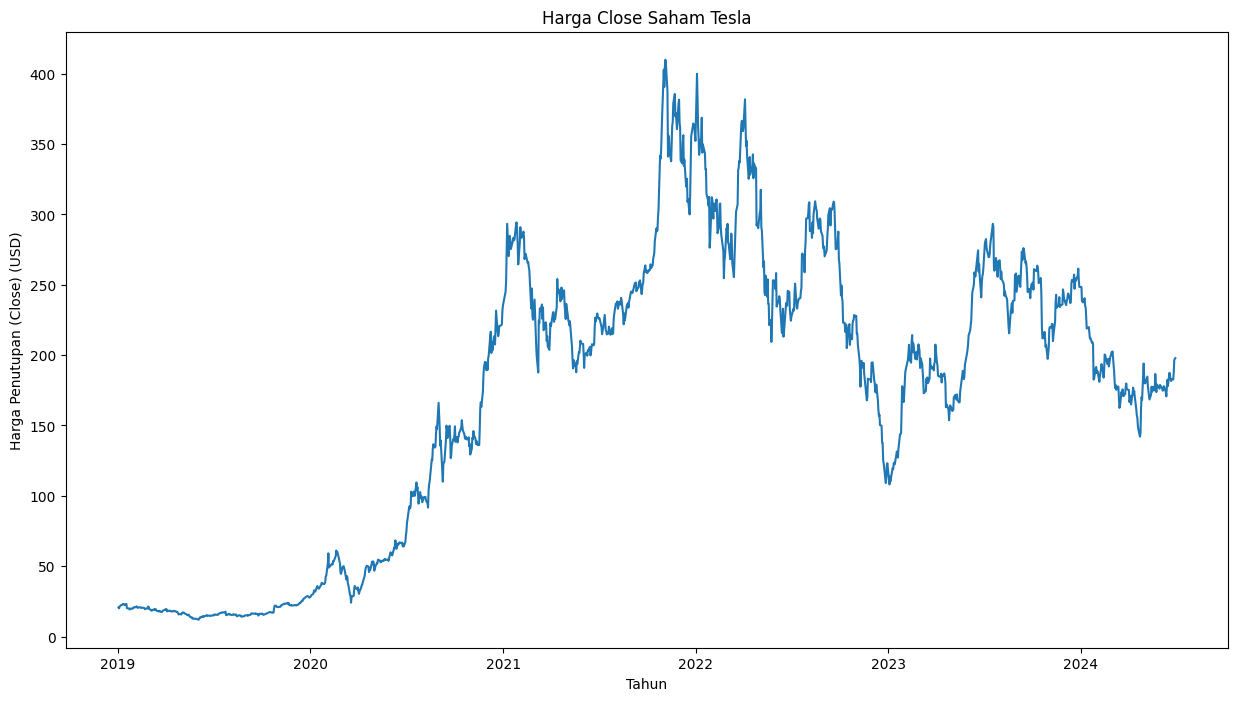

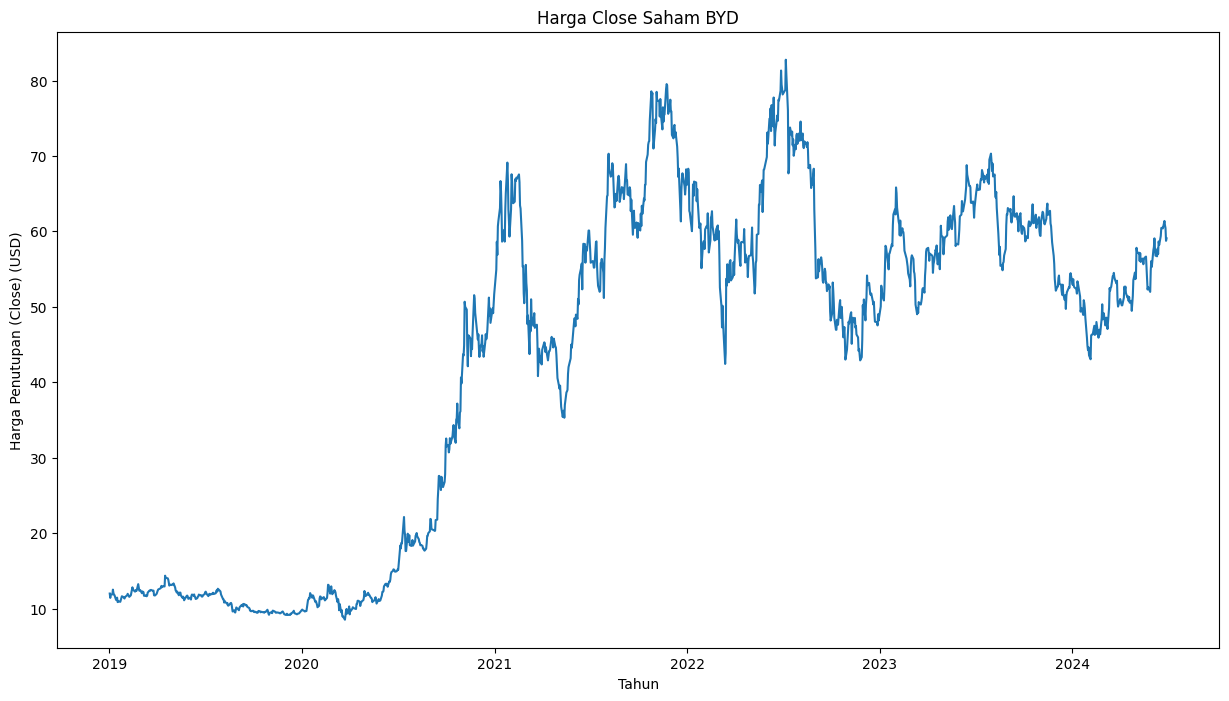

In [14]:
# Membuat grafik harga penutupan dari Tesla
plt.figure(figsize=(15, 8))
plt.plot(df['Tesla'], label='Tesla')
plt.title('Harga Close Saham Tesla')
plt.xlabel('Tahun')
plt.ylabel('Harga Penutupan (Close) (USD)')
plt.show()

# Membuat grafik harga penutupan dari BYD
plt.figure(figsize=(15, 8))
plt.plot(df['BYD'], label='BYD')
plt.title('Harga Close Saham BYD')
plt.xlabel('Tahun')
plt.ylabel('Harga Penutupan (Close) (USD)')
plt.show()


<Figure size 1800x1000 with 0 Axes>

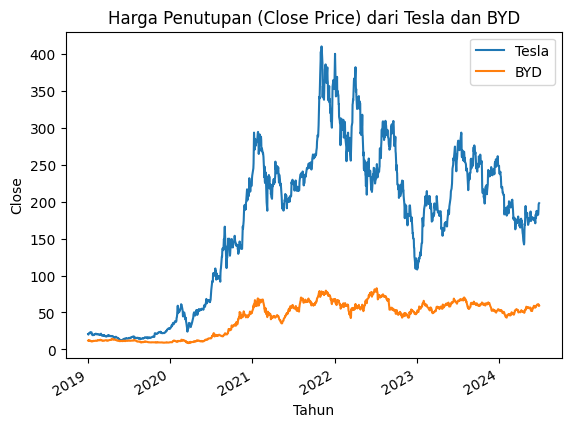

In [15]:
# Membuat grafik perbandingan harga Close dari Tesla dan BYD
plt.figure(figsize=(18, 10))
df.plot()
plt.ylabel('Close')
plt.xlabel('Tahun')
plt.title(f"Harga Penutupan (Close Price) dari Tesla dan BYD")

plt.show()

# **3. DATA PREPARATION**


Tahap *Data Preparation* adalah tahap untuk mengidentifikasi data, menyeleksi, dan melakukan pembersihan data untuk selanjutnya disusun ke dalam format yang dibutuhkan.

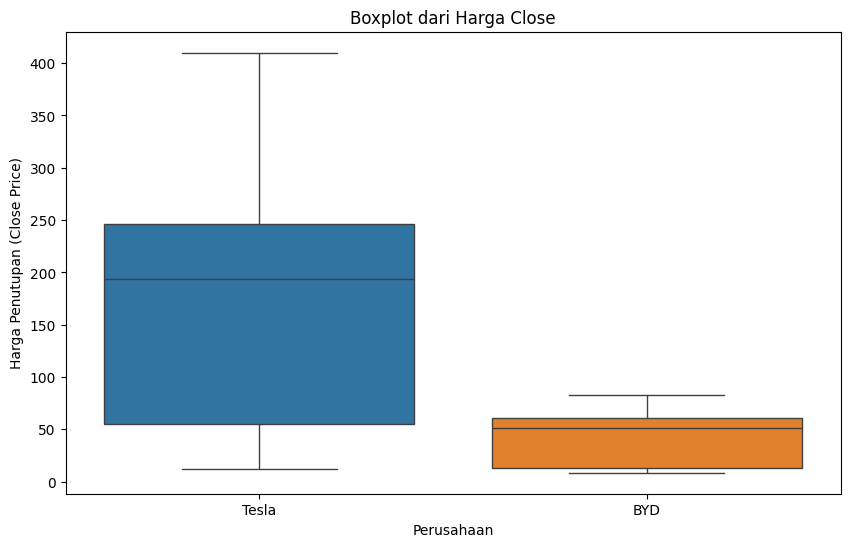

In [16]:
# Pengecekan Outlier dengan menggunakan boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.title('Boxplot dari Harga Close')
plt.xlabel('Perusahaan')
plt.ylabel('Harga Penutupan (Close Price)')
plt.show()

### **3.1. Menghitung Moving Average**
*Moving Average* adalah salah satu indikator yang dapat membantu dalam menganalisis pergerakan saham. Pada bagian ini, dilakukan penyalinan dataset 'df' terlebih dahulu sebelum dilakukan perhitungan. Bagian ini bertujuan untuk memberikan gambaran terkait pergerakan saham secara umum.


In [17]:
# Membuat salinan dataset
df_ma = df.copy()

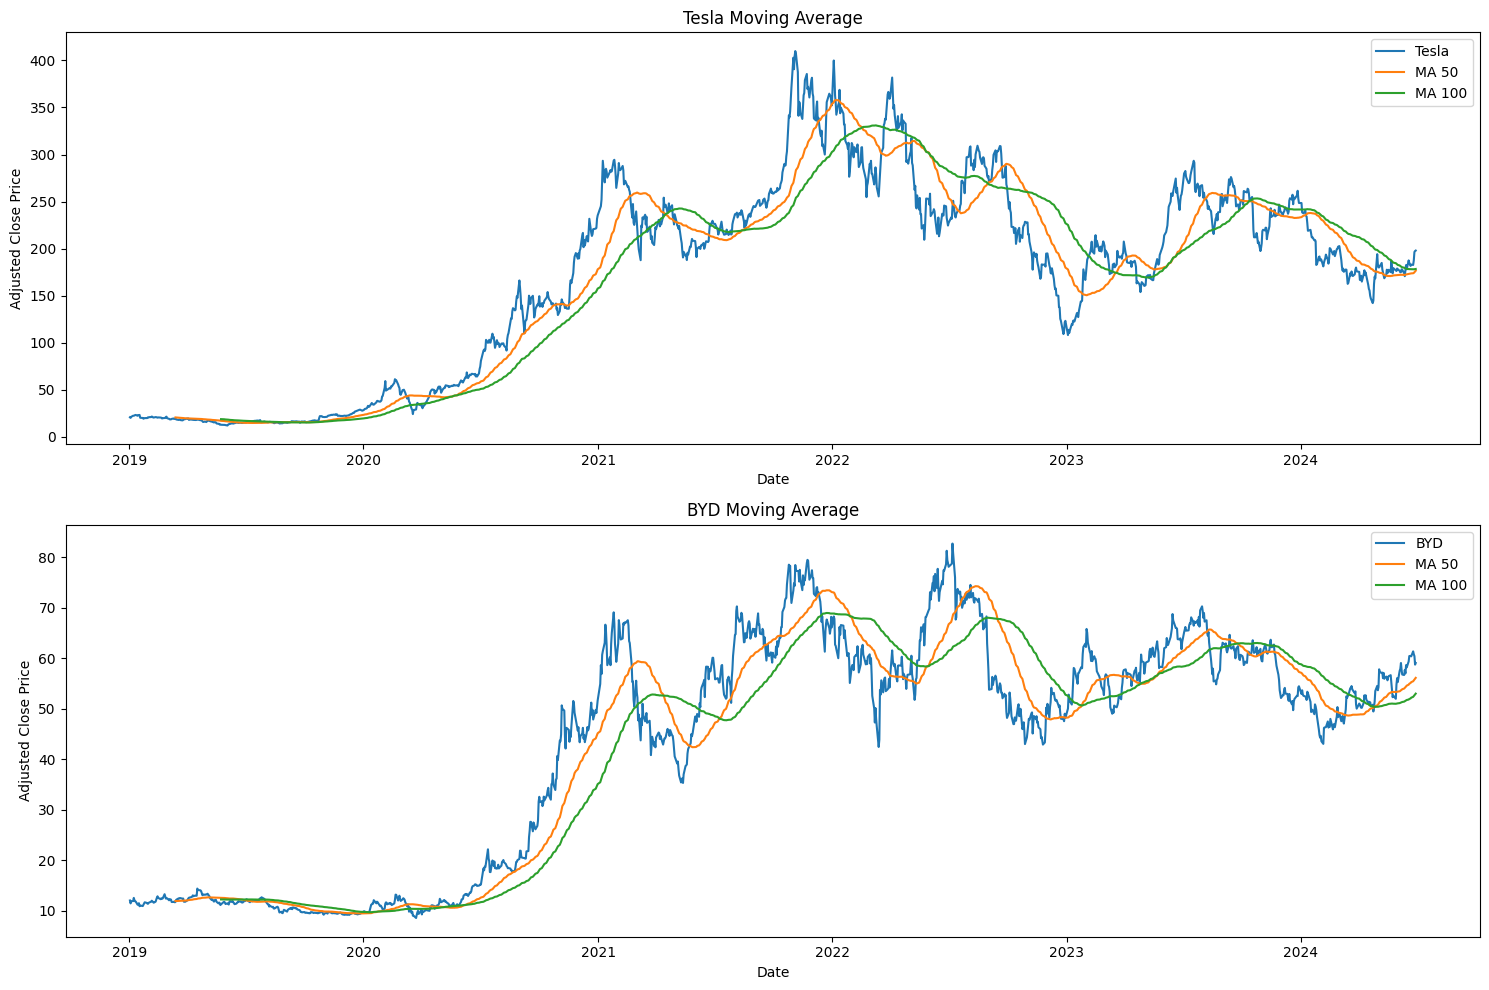

Bentuk dari dataset df_ma adalah:  (1382, 6)


,0
Tesla,0
BYD,0
Tesla_MA50,49
BYD_MA50,49
Tesla_MA100,99
BYD_MA100,99


In [18]:
# Menghitung Moving Average
ma_day = [50, 100]

for ma in ma_day:
    for company in companies:
        df_ma[f"{company}_MA{ma}"] = df_ma[company].rolling(ma).mean()

# Membuat grafik Moving Average
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# Tentukan fungsi untuk membuat plot
def plot_moving_averages(ax, company):
    ax.plot(df_ma[company], label=company)
    for ma in ma_day:
        ax.plot(df_ma[f"{company}_MA{ma}"], label=f'MA {ma}')
    ax.set_title(f'{company} Moving Average')
    ax.set_xlabel('Date')
    ax.set_ylabel('Adjusted Close Price')
    ax.legend()

# Gunakan loop untuk membuat grafik dari setiap perusahaan
for i, company in enumerate(companies):
    plot_moving_averages(axes[i], company)

plt.tight_layout()
plt.show()

# Mencetak informasi nilai null dari dataset
print('Bentuk dari dataset df_ma adalah: ', df_ma.shape)
df_ma.isnull().sum()

In [19]:
# Menangani nilai null dengan melakukan penghapusan data
df_ma.dropna(inplace=True)
print('Bentuk dari dataset df_2 setelah dilakukan penghapusan adalah: ', df_ma.shape)

Bentuk dari dataset df_2 setelah dilakukan penghapusan adalah:  (1283, 6)


In [20]:
# Menampilkan informasi dari dataset 'df_ma'
df_ma.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1283 entries, 2019-05-24 to 2024-06-28
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Tesla        1283 non-null   float64
 1   BYD          1283 non-null   float64
 2   Tesla_MA50   1283 non-null   float64
 3   BYD_MA50     1283 non-null   float64
 4   Tesla_MA100  1283 non-null   float64
 5   BYD_MA100    1283 non-null   float64
dtypes: float64(6)
memory usage: 70.2 KB


In [21]:
# Mencetak dataset 'df_ma' secara lebih rinci
df_ma

,Tesla,BYD,Tesla_MA50,BYD_MA50,Tesla_MA100,BYD_MA100
Date,,,,,,
2019-05-24,12.708667,11.230635,16.890147,12.521477,18.699793,12.199351
2019-05-28,12.580000,11.678304,16.774507,12.512913,18.618847,12.196236
2019-05-29,12.657333,11.717232,16.668333,12.500067,18.545180,12.199253
2019-05-30,12.548000,11.571253,16.562667,12.485080,18.458867,12.196431
2019-05-31,12.344000,11.289028,16.444747,12.462113,18.359000,12.190592
...,...,...,...,...,...,...
2024-06-24,182.580002,61.380001,173.779800,55.452590,177.978600,52.364536
2024-06-25,187.350006,60.820000,174.105800,55.632797,177.979200,52.530117
2024-06-26,196.369995,60.439999,174.803600,55.817426,178.054300,52.688155


In [22]:
# Memastikan keberadaan nilai null kembali setelah penghapusan nilai null
df_ma.isnull().sum()

,0
Tesla,0
BYD,0
Tesla_MA50,0
BYD_MA50,0
Tesla_MA100,0
BYD_MA100,0


### **3.2. Data Cleaning**
*Outlier* adalah data pencilan yang berbeda dari mayoritas data. Pengecekan diperlukan karena keberadaan *outlier* dapat mempengaruhi pengolahan data dan prediksi.

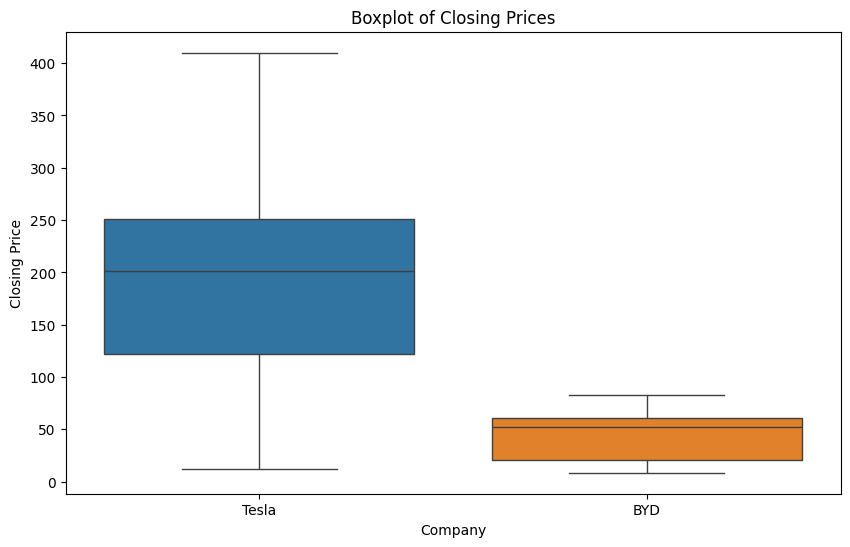

In [23]:
# Pengecekan Outlier dengan menggunakan boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_ma[['Tesla', 'BYD']])
plt.title('Boxplot of Closing Prices')
plt.xlabel('Company')
plt.ylabel('Closing Price')
plt.show()

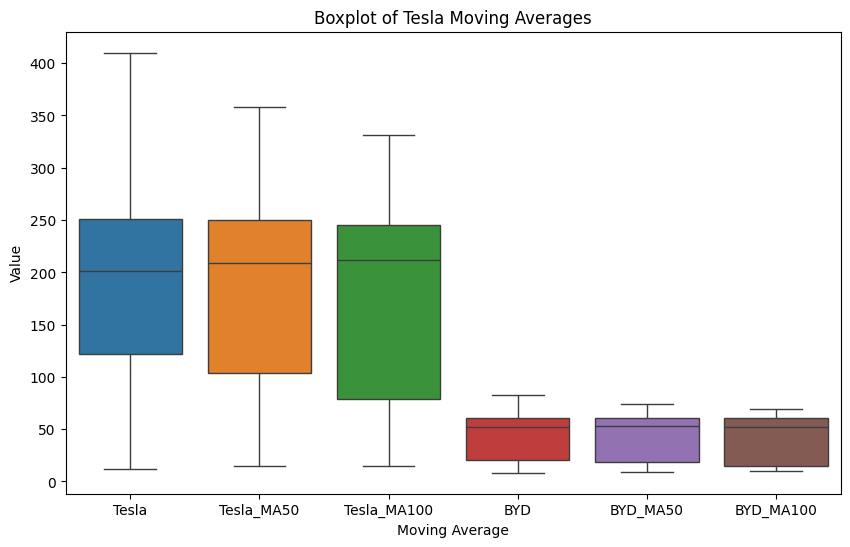

In [24]:
# Pengecekan Outlier dengan menggunakan boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_ma[['Tesla', 'Tesla_MA50', 'Tesla_MA100',
                        'BYD', 'BYD_MA50', 'BYD_MA100']])
plt.title('Boxplot of Tesla Moving Averages')
plt.xlabel('Moving Average')
plt.ylabel('Value')
plt.show()

In [25]:
# BAGIAN INI HANYA DIGUNAKAN UNTUK MENGATASI OUTLIER
"""# Menghitung IQR
Q1 = df_ma['Tesla'].quantile(0.25)
Q3 = df_ma['Tesla'].quantile(0.75)
IQR = Q3 - Q1

# Menentukan batas atas dan bawah
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR"""

"# Menghitung IQR\nQ1 = df_ma['Tesla'].quantile(0.25)\nQ3 = df_ma['Tesla'].quantile(0.75)\nIQR = Q3 - Q1\n\n# Menentukan batas atas dan bawah\nupper_bound = Q3 + 1.5 * IQR\nlower_bound = Q1 - 1.5 * IQR"

In [26]:
"""# Mencari baris dengan nilai outlier
outliers = df_ma[
    (df_ma['Tesla'] < lower_bound) | (df_ma['Tesla'] > upper_bound)]

outliers"""

"# Mencari baris dengan nilai outlier\noutliers = df_ma[\n    (df_ma['Tesla'] < lower_bound) | (df_ma['Tesla'] > upper_bound)]\n\noutliers"

In [27]:
"""# Mengganti outlier dengan nilai median
median_value = df_ma['Tesla'].median()
df_ma['Tesla'] = np.where((df_ma['Tesla'] < lower_bound) | (df_ma['Tesla'] > upper_bound),
                            median_value, df_ma['Tesla'])"""

"# Mengganti outlier dengan nilai median\nmedian_value = df_ma['Tesla'].median()\ndf_ma['Tesla'] = np.where((df_ma['Tesla'] < lower_bound) | (df_ma['Tesla'] > upper_bound),\n                            median_value, df_ma['Tesla'])"

In [28]:
"""# Pengecekan Outlier dengan menggunakan boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_ma[['Tesla', 'Tesla_MA50', 'Tesla_MA100']])
plt.title('Boxplot of Tesla Moving Averages')
plt.xlabel('Moving Average')
plt.ylabel('Value')
plt.show()"""

"# Pengecekan Outlier dengan menggunakan boxplot\nplt.figure(figsize=(10, 6))\nsns.boxplot(data=df_ma[['Tesla', 'Tesla_MA50', 'Tesla_MA100']])\nplt.title('Boxplot of Tesla Moving Averages')\nplt.xlabel('Moving Average')\nplt.ylabel('Value')\nplt.show()"

In [29]:
"""# Assuming 'outliers' DataFrame has an index that matches the index of 'df_ma'
df_ma.loc[outliers.index]"""

"# Assuming 'outliers' DataFrame has an index that matches the index of 'df_ma'\ndf_ma.loc[outliers.index]"

In [30]:
df_ma

,Tesla,BYD,Tesla_MA50,BYD_MA50,Tesla_MA100,BYD_MA100
Date,,,,,,
2019-05-24,12.708667,11.230635,16.890147,12.521477,18.699793,12.199351
2019-05-28,12.580000,11.678304,16.774507,12.512913,18.618847,12.196236
2019-05-29,12.657333,11.717232,16.668333,12.500067,18.545180,12.199253
2019-05-30,12.548000,11.571253,16.562667,12.485080,18.458867,12.196431
2019-05-31,12.344000,11.289028,16.444747,12.462113,18.359000,12.190592
...,...,...,...,...,...,...
2024-06-24,182.580002,61.380001,173.779800,55.452590,177.978600,52.364536
2024-06-25,187.350006,60.820000,174.105800,55.632797,177.979200,52.530117
2024-06-26,196.369995,60.439999,174.803600,55.817426,178.054300,52.688155


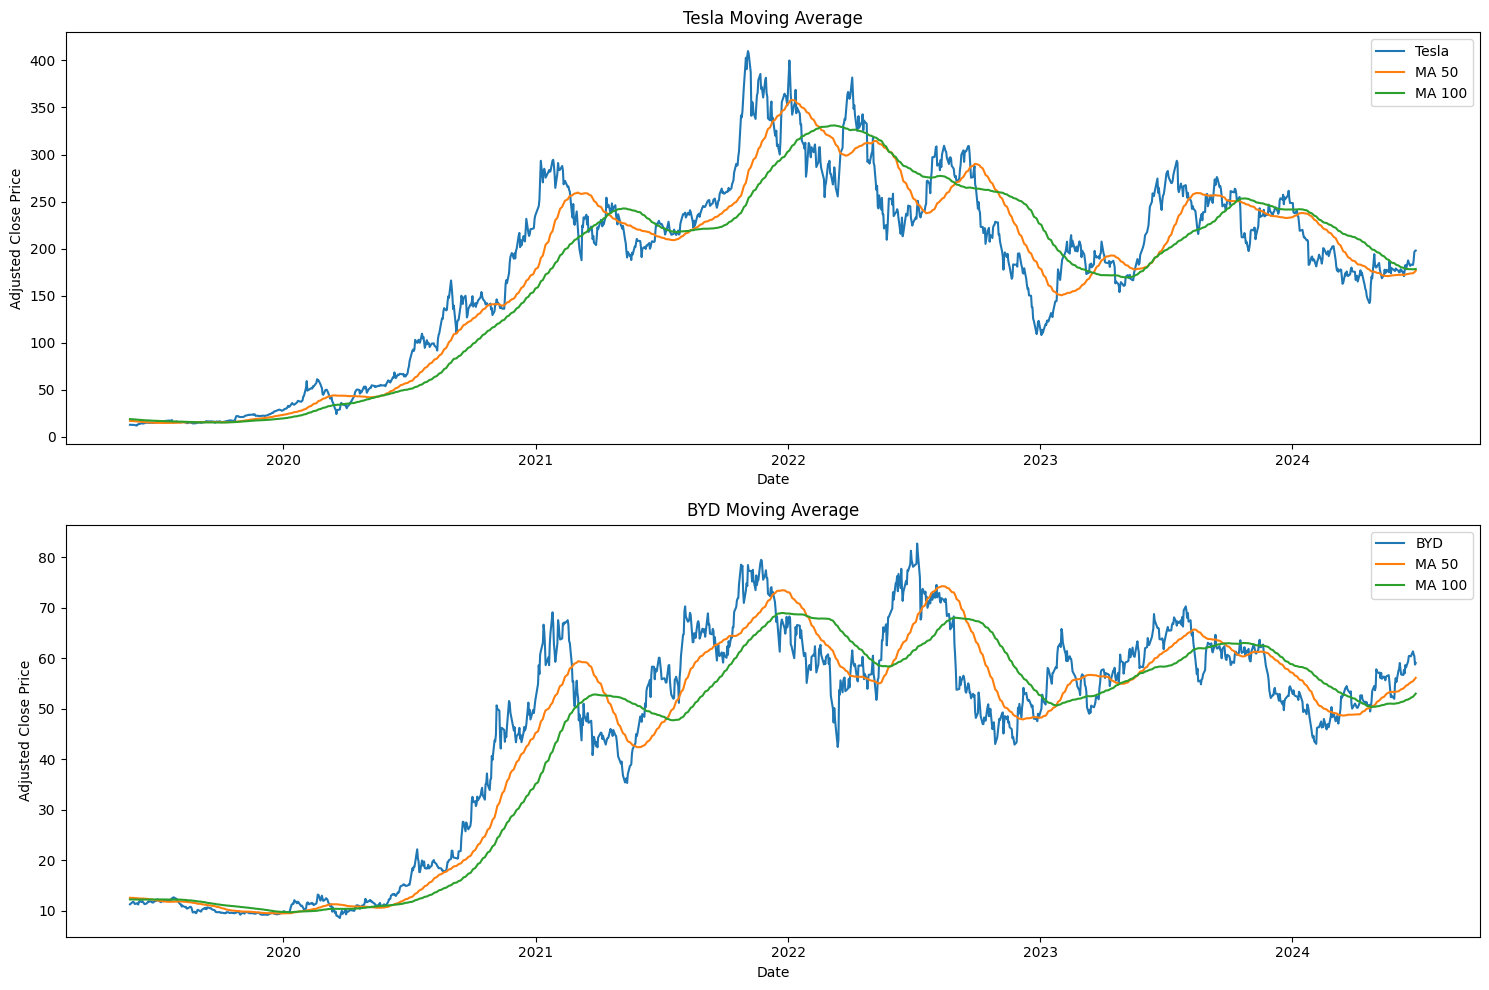

In [31]:
# Membuat grafik Moving Average terbaru
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# Tentukan fungsi untuk membuat plot
def plot_moving_averages(ax, company):
    ax.plot(df_ma[company], label=company)
    for ma in ma_day:
        ax.plot(df_ma[f"{company}_MA{ma}"], label=f'MA {ma}')
    ax.set_title(f'{company} Moving Average')
    ax.set_xlabel('Date')
    ax.set_ylabel('Adjusted Close Price')
    ax.legend()

# Gunakan loop untuk membuat grafik dari setiap perusahaan
for i, company in enumerate(companies):
    plot_moving_averages(axes[i], company)

plt.tight_layout()
plt.show()

### **3.3. Persiapan Membuat Model LSTM**
Untuk pengolahan data lebih lanjut, dilakukan penyalinan dataset emnjadi 'df_2' untuk memastikan integritas dari data asli tetap terjaga pada dataset 'df'.

In [32]:
# Bagian ini, df_2 menggunakan data asli dari dataset yang tidak memiliki hasil perhitungan moving average
# Membuat salinan database 'df'
df_2 = df.copy()

In [33]:
# Mencetak kembali dataset df_2
df_2

,Tesla,BYD
Date,,
2019-01-02,20.674667,11.989724
2019-01-03,20.024000,11.415542
2019-01-04,21.179333,11.853478
2019-01-07,22.330667,11.872941
2019-01-08,22.356667,12.505517
...,...,...
2024-06-24,182.580002,61.380001
2024-06-25,187.350006,60.820000
2024-06-26,196.369995,60.439999


In [34]:
# Menyalin kembali dataset
df_3 = df_2.copy()
df_3 = df_3.filter(['Date', 'Tesla', 'BYD'])
df_3

,Tesla,BYD
Date,,
2019-01-02,20.674667,11.989724
2019-01-03,20.024000,11.415542
2019-01-04,21.179333,11.853478
2019-01-07,22.330667,11.872941
2019-01-08,22.356667,12.505517
...,...,...
2024-06-24,182.580002,61.380001
2024-06-25,187.350006,60.820000
2024-06-26,196.369995,60.439999


# **4. DATA MODELLING**

## **4.1. Scaling & Normalisasi Data**
Scaling adalah tahap normalisasi untuk mengonversi nilai dari variabel independen ke dalam rentang 0 sampai 1. Teknik ini berfungsi untuk menyeimbangkan nilai data.

In [35]:
# Scale dataset 'Adj Close'
scale_tesla = MinMaxScaler(feature_range=(0,1))
df_3[['scaled_tesla']]= scale_tesla.fit_transform(df_3[['Tesla']])
np.set_printoptions(threshold=np.inf)

scale_byd = MinMaxScaler(feature_range=(0,1))
df_3[['scaled_byd']]= scale_byd.fit_transform(df_3[['BYD']])
np.set_printoptions(threshold=np.inf)

In [36]:
print(df_3)

                 Tesla        BYD  scaled_tesla  scaled_byd
Date                                                       
2019-01-02   20.674667  11.989724      0.021966    0.046769
2019-01-03   20.024000  11.415542      0.020331    0.039035
2019-01-04   21.179333  11.853478      0.023234    0.044934
2019-01-07   22.330667  11.872941      0.026126    0.045196
2019-01-08   22.356667  12.505517      0.026192    0.053717
...                ...        ...           ...         ...
2024-06-24  182.580002  61.380001      0.428724    0.712072
2024-06-25  187.350006  60.820000      0.440708    0.704529
2024-06-26  196.369995  60.439999      0.463369    0.699410
2024-06-27  197.419998  58.750000      0.466007    0.676645
2024-06-28  197.880005  59.080002      0.467162    0.681090

[1382 rows x 4 columns]


In [37]:
# Menghitung nilai minimum dan maksimum
min_tesla = df_3['Tesla'].min()
max_tesla = df_3['Tesla'].max()
min_scaled_tesla = df_3['scaled_tesla'].min()
max_scaled_tesla = df_3['scaled_tesla'].max()

print(f"Rentang data aktual 'Close' Tesla: {min_tesla} sampai {max_tesla}")
print(f"Rentang data hasil scaling 'scaled_tesla': {min_scaled_tesla} sampai {max_scaled_tesla}")

# Menghitung nilai minimum dan maksimum
min_byd = df_3['BYD'].min()
max_byd = df_3['BYD'].max()
min_scaled_byd = df_3['scaled_byd'].min()
max_scaled_byd = df_3['scaled_byd'].max()

print(f"\nRentang data aktual 'Close': {min_byd} sampai {max_byd}")
print(f"Rentang data hasil scaling 'scaled_byd': {min_scaled_byd} sampai {max_scaled_byd}")

Rentang data aktual 'Close' Tesla: 11.9313325881958 sampai 409.9700012207031
Rentang data hasil scaling 'scaled_tesla': 0.0 sampai 1.0

Rentang data aktual 'Close': 8.517727851867676 sampai 82.75496673583984
Rentang data hasil scaling 'scaled_byd': 0.0 sampai 1.0


## **4.2. Split Dataset**
Membagi dataset ke dalam data latih dan data uji

#### **Membagi Dataset ke Dalam Data Latih dan Data Uji**

In [38]:
# Fungsi untuk membagi dataset ke dalam train dan test data
def split_data(df, train_size):
  size = int(len(df) * train_size)
  train, test = df.iloc[0:size], df.iloc[size:len(df)]
  return train, test

In [39]:
# Membagi data harga penutupan saham Tesla yang telah di-scaling
train_tesla, test_tesla = split_data(df_3['scaled_tesla'], 0.8) #80% Train

In [40]:
# Membagi data harga penutupan saham BYD yang telah di-scaling
train_byd, test_byd = split_data(df_3['scaled_byd'], 0.8) #80% Train

In [41]:
# Melihat ukuran data train dan test
# Mencetak ukuran set pelatihan dan pengujian
print(f"Jumlah data latih Tesla : {len(train_tesla)} ({len(train_tesla)/len(df_3)*100:.2f}%)")
print(f"Jumlah data uji Tesla: {len(test_tesla)} ({len(test_tesla)/len(df_3)*100:.2f}%)")

# Mencetak ukuran set pelatihan dan pengujian
print(f"Jumlah data latih pelatihan BYD: {len(train_byd)} ({len(train_byd)/len(df_3)*100:.2f}%)")
print(f"Jumlah data uji BYD: {len(test_byd)} ({len(test_byd)/len(df_3)*100:.2f}%)\n")

print(f"Data Latih menggunakan data harga saham sejak \n", train_tesla.index[0], " sampai ", train_tesla.index[-1])
print(f"Data Uji menggunakan data harga saham sejak \n", test_tesla.index[0], " sampai ", test_tesla.index[-1])

Jumlah data latih Tesla : 1105 (79.96%)
Jumlah data uji Tesla: 277 (20.04%)
Jumlah data latih pelatihan BYD: 1105 (79.96%)
Jumlah data uji BYD: 277 (20.04%)

Data Latih menggunakan data harga saham sejak 
 2019-01-02 00:00:00  sampai  2023-05-22 00:00:00
Data Uji menggunakan data harga saham sejak 
 2023-05-23 00:00:00  sampai  2024-06-28 00:00:00


In [42]:
print(train_tesla)
print(train_byd)

Date
2019-01-02    0.021966
2019-01-03    0.020331
2019-01-04    0.023234
2019-01-07    0.026126
2019-01-08    0.026192
                ...   
2023-05-16    0.388376
2023-05-17    0.406816
2023-05-18    0.414429
2023-05-19    0.422594
2023-05-22    0.444526
Name: scaled_tesla, Length: 1105, dtype: float64
Date
2019-01-02    0.046769
2019-01-03    0.039035
2019-01-04    0.044934
2019-01-07    0.045196
2019-01-08    0.053717
                ...   
2023-05-16    0.704216
2023-05-17    0.698934
2023-05-18    0.697482
2023-05-19    0.710026
2023-05-22    0.738812
Name: scaled_byd, Length: 1105, dtype: float64


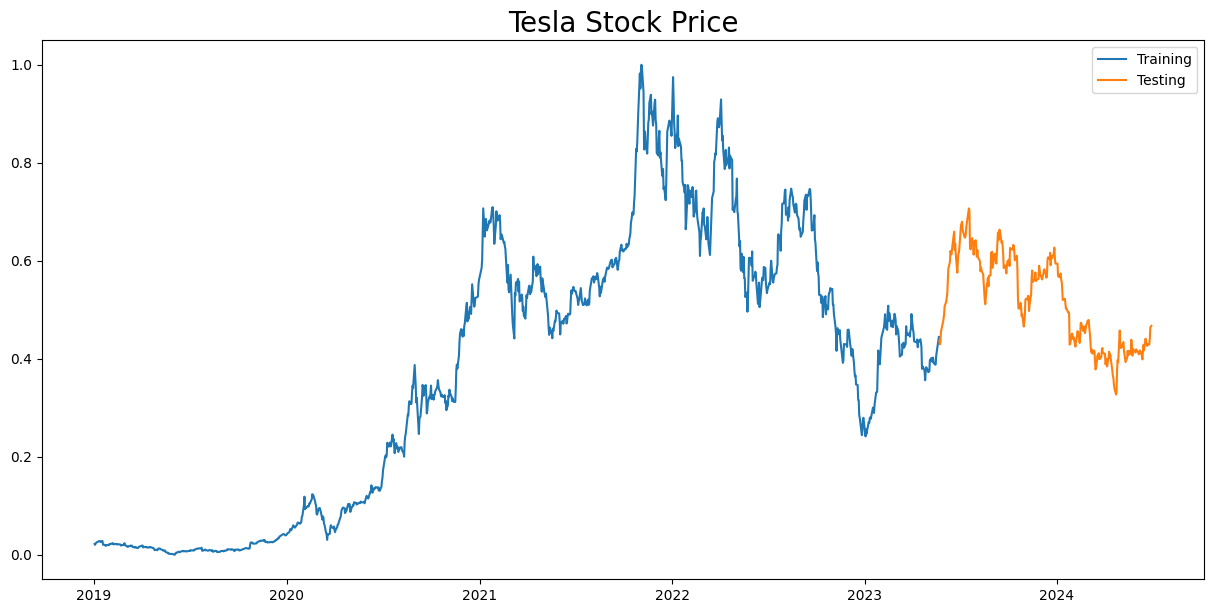

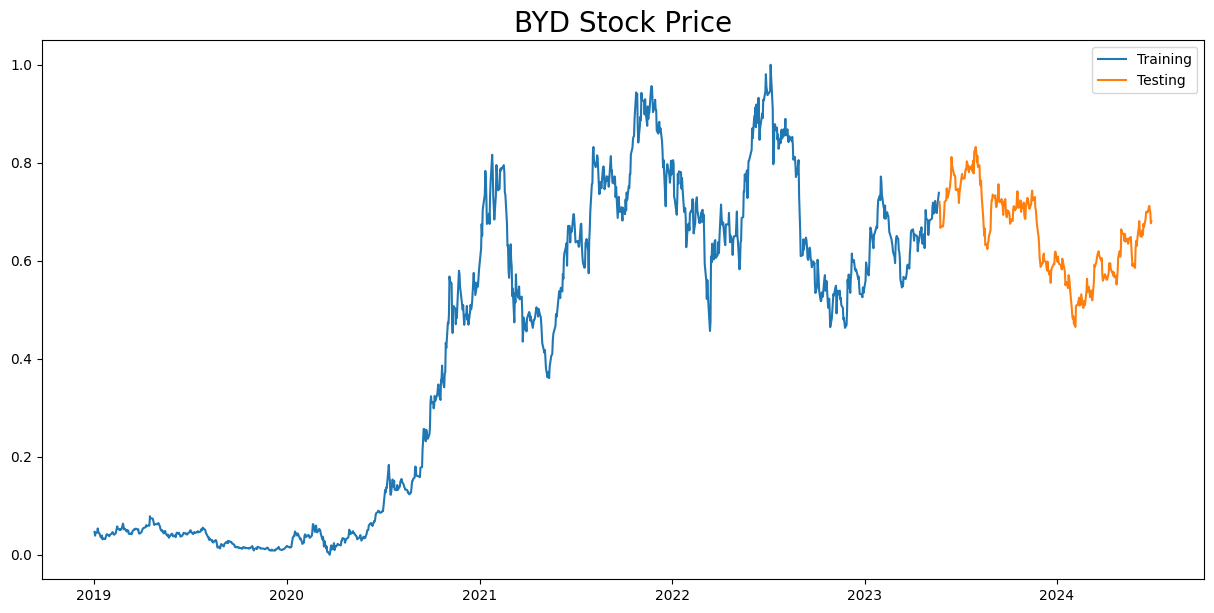

In [43]:
# Membuat grafik untuk menunjukkan perbandingan train dan test data Tesla
plt.figure(figsize=(15,7))
plt.plot(train_tesla)
plt.plot(test_tesla)
plt.legend(labels=['Training', 'Testing'])
plt.title('Tesla Stock Price', fontsize=20)
plt.show()

# Membuat grafik untuk menunjukkan perbandingan train dan test data BYD
plt.figure(figsize=(15,7))
plt.plot(train_byd)
plt.plot(test_byd)
plt.legend(labels=['Training', 'Testing'])
plt.title('BYD Stock Price', fontsize=20)
plt.show()

#### **Membagi Dataset ke Dalam Array 2 Dimensi (X dan Y)**

In [44]:
# Fungsi untuk membagi train dan test data ke dalam bentuk array X dan Y
def split_target(df, look_back=1):
    X, Y = [], []
    for i in range(len(df) - look_back):
        a = df[i:(i + look_back), 0]
        X.append(a)
        Y.append(df[i + look_back, 0])
    return np.array(X), np.array(Y)

In [45]:
# Membagi train_tesla dan test_tesla menjadi array 2 dimensi
X_train_tesla, Y_train_tesla = split_target(train_tesla.values.reshape(len(train_tesla), 1))
X_test_tesla, Y_test_tesla = split_target(test_tesla.values.reshape(len(test_tesla), 1))

In [46]:
# Mengubah bentuk train_tesla dan test_tesla menjadi array 2 dimensi
# agar dapat diproses untuk model LSTM
X_train_tesla = X_train_tesla.reshape((X_train_tesla.shape[0], 1, X_train_tesla.shape[1]))
X_test_tesla = X_test_tesla.reshape((X_test_tesla.shape[0], 1, X_test_tesla.shape[1]))

In [47]:
# Membagi train_tesla dan test_tesla menjadi array 2 dimensi
X_train_byd, Y_train_byd = split_target(train_byd.values.reshape(len(train_byd), 1))
X_test_byd, Y_test_byd = split_target(test_byd.values.reshape(len(test_byd), 1))

In [48]:
# Mengubah bentuk train_byd dan test_byd menjadi array 2 dimensi
# agar dapat diproses untuk model LSTM
X_train_byd = X_train_byd.reshape((X_train_byd.shape[0], 1, X_train_byd.shape[1]))
X_test_byd = X_test_byd.reshape((X_test_byd.shape[0], 1, X_test_byd.shape[1]))

## **4.3. Membuat Model LSTM**
Pada bagian ini, dibuat model LSTM yang nantinya akan digunakan untuk prediksi. Tahap ini juga akan dilakukan pengimplementasian algoritma dan model untuk menemukan, mengidentifikasi, dan menampilkan pola dari harga saham.

Pada bagian ini, model dipisahkan untuk data Tesla dan BYD untuk menghindari bias yang dapat terjadi.

In [49]:
drop_out = 0.2

In [50]:
# Membuat model LSTM untuk Tesla
model_tesla = Sequential([LSTM(128, input_shape=(1, 1), return_sequences=True),
                    Dropout(drop_out),
                    LSTM(64),
                    Dropout(drop_out),
                    Dense(32, activation='relu'),
                    Dense(1)])

In [51]:
# Membuat model LSTM untuk BYD
model_byd = Sequential([LSTM(128, input_shape=(1, 1), return_sequences=True),
                    Dropout(drop_out),
                    LSTM(64),
                    Dropout(drop_out),
                    Dense(32, activation='relu'),
                    Dense(1)])

In [52]:
model_tesla.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,081 (461.25 KB)

 Trainable params: 118,081 (461.25 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
model_byd.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 1, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,081 (461.25 KB)

 Trainable params: 118,081 (461.25 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# Menggunakan optimizer dalam proses kompilasi model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_tesla.compile(optimizer=optimizer,metrics=["mae"],loss='mse')
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_byd.compile(optimizer=optimizer,metrics=["mae"],loss='mse')

In [55]:
# Menyimpan model
model_tesla.save('tesla_stock_price.keras')
model_byd.save('byd_stock_price.keras')

In [56]:
# Callbacks
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_mae') is not None and logs.get('val_mae') < 0.01:
      self.model.stop_training = True

## **4.4 Implementasi Model dan Visualisasi**
Mengimplementasikan data latih dan data uji yang telah dipisahkan ke dalam model yang telah dibuat.

### **4.4.1 Mengaplikasikan Model pada Data Tesla**

In [57]:
# Memanggil model LSTM dengan data tesla sebagai parameter
saham_tesla = model_tesla.fit(X_train_tesla,
                    Y_train_tesla,
                    epochs=150,
                    batch_size=64,
                    validation_data=(X_test_tesla, Y_test_tesla),
                    shuffle=False,
                    callbacks=[Callback()])

Epoch 1/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.1043 - mae: 0.1972 - val_loss: 0.2642 - val_mae: 0.5058
Epoch 2/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0992 - mae: 0.1873 - val_loss: 0.2510 - val_mae: 0.4927
Epoch 3/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0942 - mae: 0.1814 - val_loss: 0.2375 - val_mae: 0.4789
Epoch 4/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0895 - mae: 0.1791 - val_loss: 0.2238 - val_mae: 0.4645
Epoch 5/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0845 - mae: 0.1779 - val_loss: 0.2095 - val_mae: 0.4489
Epoch 6/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0797 - mae: 0.1771 - val_loss: 0.1945 - val_mae: 0.4321
Epoch 7/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0747 - mae: 0.1768 - val_loss: 0.1787 - val_mae: 0.4136
Epoch 8/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0696 - mae: 0.1763 - val_loss: 0.1620 - val_mae: 0.3932
Epoch 9/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - lo

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


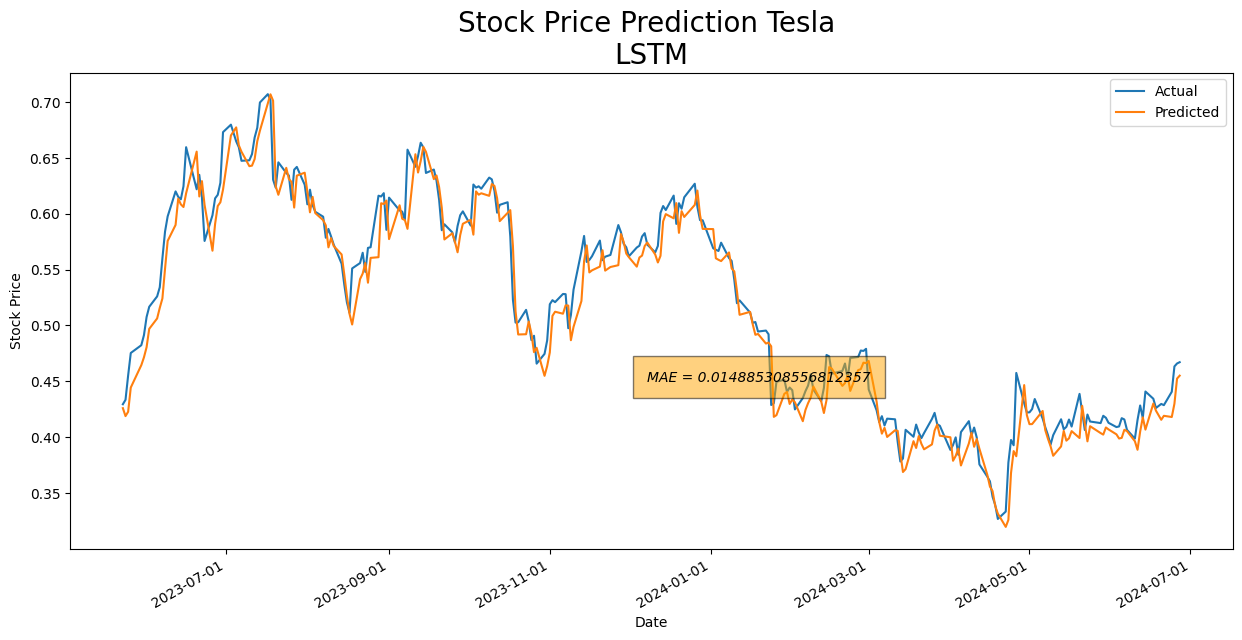

MAE:  0.014885308556812357
MSE:  0.00038530379317683176
RMSE:  0.019629156710792028
MAPE:  0.02909356210182543


In [58]:
# Melakukan prediksi dengan test data
pred = model_tesla.predict(X_test_tesla)
pred_tesla = np.array(pred).reshape(-1)

# Membuat plot untuk nilai aktual dan prediksi dari saham Tesla
plt.figure(figsize=(15, 7))
plt.plot(test_tesla.index[:-1], Y_test_tesla, label='Actual')
plt.plot(test_tesla.index[:-1], pred_tesla, label='Predicted')
plt.text(test_tesla.index[len(test_tesla)//2], 0.45,
         f"MAE = {mean_absolute_error(Y_test_tesla, pred_tesla)}",
         style='italic', bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 10})
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction Tesla \nLSTM', fontsize=20)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

# Evaluasi model prediksi
mae_tesla = mean_absolute_error(Y_test_tesla, pred_tesla)
mse_tesla = mean_squared_error(Y_test_tesla, pred_tesla)
rmse_tesla = np.sqrt(mean_squared_error(Y_test_tesla, pred_tesla))
mape_tesla = mean_absolute_percentage_error(Y_test_tesla, pred_tesla)
print('MAE: ', mae_tesla)
print('MSE: ', mse_tesla)
print('RMSE: ', rmse_tesla)
print('MAPE: ', mape_tesla)

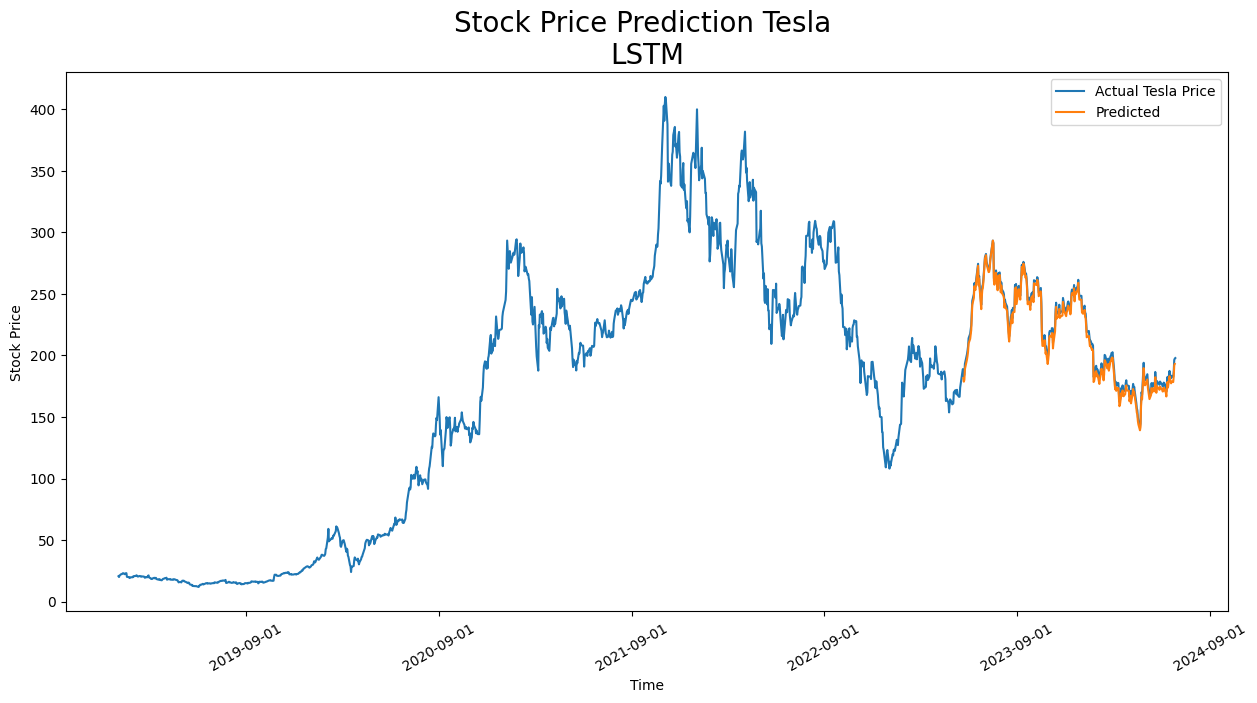

In [59]:
# Menampilkan grafik harga saham penutupan perusahaan Tesla
# Membuat array temporer dengan 2 kolom, kolom pertama diisi dengan prediksi saham Tesla.
temp_array = np.zeros((np.array(pred_tesla).reshape(-1, 1).shape[0], 2))
temp_array[:, 0] = np.array(pred_tesla).reshape(-1, 1)[:, 0]

# Melakukan tranformasi inverse pada array sementara
y_pred_original = scale_tesla.inverse_transform(temp_array)

# Mengekstrak prediksi dari Tesla
y_pred_original = y_pred_original[:, 0]

# Membuat plot untuk nilai aktual dan prediksi dari saham Tesla
plt.figure(figsize=(15, 7))
plt.plot(df_3.index, df_3['Tesla'], label='Actual Tesla Price')
plt.plot(test_tesla.index[:-1], y_pred_original,label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction Tesla \nLSTM', fontsize=20)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))

# Merotasi x-axis labels
plt.xticks(rotation=30)

plt.legend()
plt.show()

### **4.4.2 Mengaplikasikan Model pada Data BYD**

In [60]:
# Memanggil model LSTM dengan data tesla sebagai parameter
saham_byd = model_byd.fit(X_train_byd,
                    Y_train_byd,
                    epochs=200,
                    batch_size=32,
                    validation_data=(X_test_byd, Y_test_byd),
                    shuffle=False,
                    callbacks=[Callback()])

Epoch 1/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.1066 - mae: 0.1926 - val_loss: 0.3942 - val_mae: 0.6224
Epoch 2/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0962 - mae: 0.1715 - val_loss: 0.3577 - val_mae: 0.5924
Epoch 3/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0866 - mae: 0.1601 - val_loss: 0.3177 - val_mae: 0.5579
Epoch 4/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0766 - mae: 0.1628 - val_loss: 0.2728 - val_mae: 0.5163
Epoch 5/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0670 - mae: 0.1696 - val_loss: 0.2229 - val_mae: 0.4659
Epoch 6/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0577 - mae: 0.1775 - val_loss: 0.1687 - val_mae: 0.4041
Epoch 7/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0506 - mae: 0.1879 - val_loss: 0.1172 - val_mae: 0.3352
Epoch 8/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0479 - mae: 0.1998 - val_loss: 0.0746 - val_mae: 0.2654
Epoch 9/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.04

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


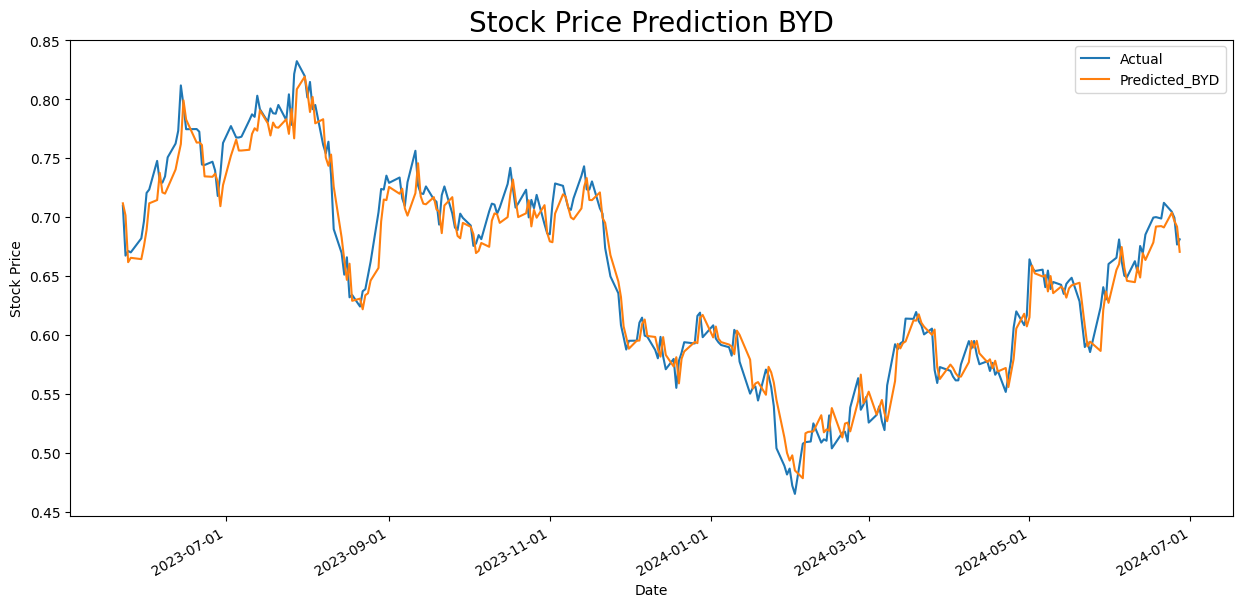

MAE:  0.013555672794324623
MSE:  0.00028974190921619397
RMSE:  0.01702180687283797
MAPE:  0.020861868759650487


In [61]:
# Melakukan prediksi dengan test data
pred = model_byd.predict(X_test_byd)
pred_byd = np.array(pred).reshape(-1)

# Membuat plot untuk nilai aktual dan prediksi dari saham byd
plt.figure(figsize=(15, 7))
plt.plot(test_byd.index[:-1], Y_test_byd, label='Actual')
plt.plot(test_byd.index[:-1], pred_byd, label='Predicted_BYD')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction BYD', fontsize=20)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

# Evaluasi model prediksi dengan batch size 150 dan epoch 32
mae_byd = mean_absolute_error(Y_test_byd, pred_byd)
mse_byd = mean_squared_error(Y_test_byd, pred_byd)
rmse_byd = np.sqrt(mean_squared_error(Y_test_byd, pred_byd))
mape_byd = mean_absolute_percentage_error(Y_test_byd, pred_byd)
print('MAE: ', mae_byd)
print('MSE: ', mse_byd)
print('RMSE: ', rmse_byd)
print('MAPE: ', mape_byd)

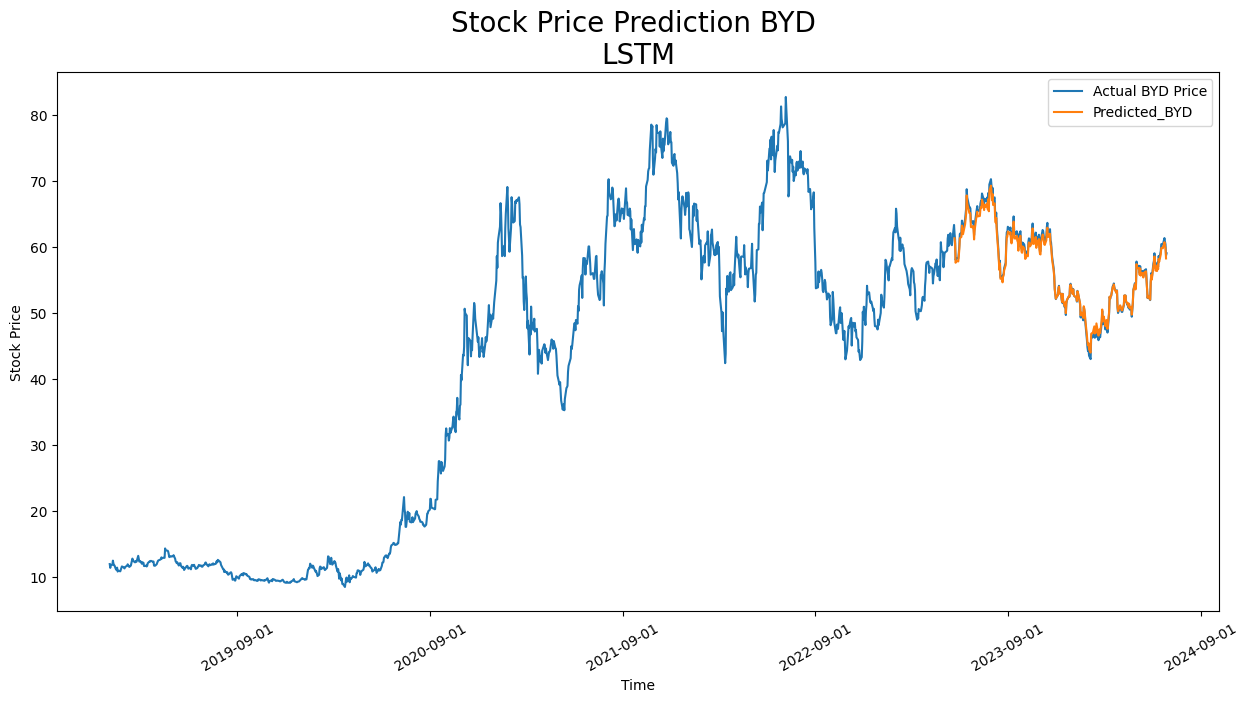

In [62]:
# Menampilkan grafik harga saham penutupan perusahaan BYD
# Membuat array temporer dengan 2 kolom, kolom pertama diisi dengan prediksi saham BYD.
temp_array_byd = np.zeros((pred_byd.shape[0], 2))
temp_array_byd[:, 0] = 0
temp_array_byd[:, 1] = pred_byd

# Melakukan tranformasi inverse pada array sementara
y_pred_original = scale_byd.inverse_transform(temp_array_byd)

# Mengekstrak prediksi dari byd
y_pred_original = y_pred_original[:, 1]

# Membuat plot untuk nilai aktual dan prediksi dari saham byd
plt.figure(figsize=(15, 7))
plt.plot(df_3.index, df_3['BYD'], label='Actual BYD Price')
plt.plot(test_byd.index[:-1], y_pred_original, label='Predicted_BYD')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction BYD \nLSTM', fontsize=20)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))

# Merotasi x-axis labels
plt.xticks(rotation=30)

plt.legend()
plt.show()

# **5. EVALUATION**


Bagian ini adalah bagian untuk menilai/mengevaluasi model yang telah digunakan serta mengukur tingkat akurasi model.

### **Evaluasi Model LSTM**

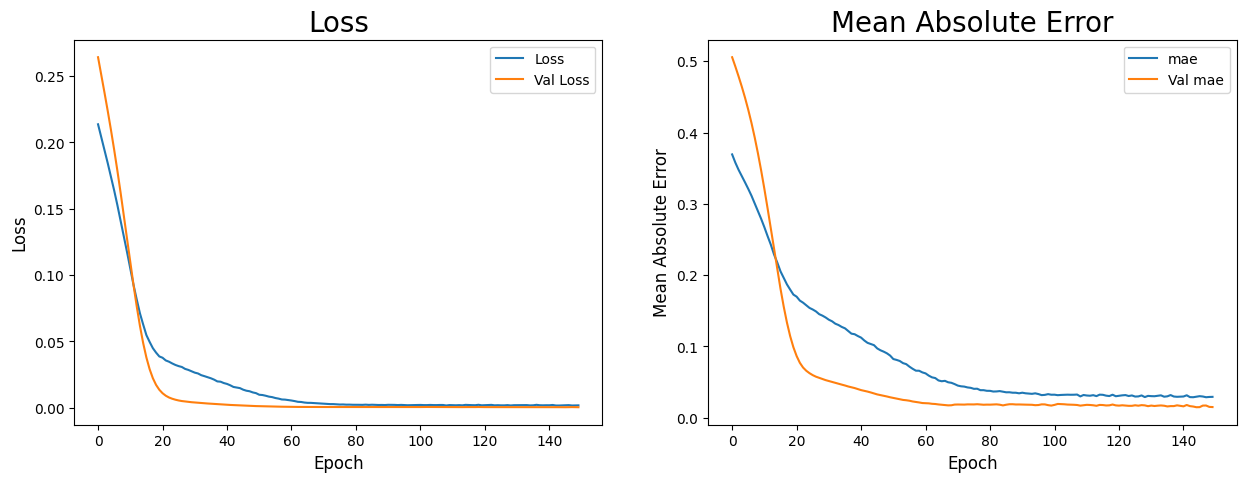

In [63]:
# Membuat grafik untuk menunjukkan nilai Loss dan MAER dari model 'saham_tesla'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Loss
ax1.plot(saham_tesla.history['loss'])
ax1.plot(saham_tesla.history['val_loss'])
ax1.legend(['Loss','Val Loss'])
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss', fontsize=20)

# MAE
ax2.plot(saham_tesla.history['mae'])
ax2.plot(saham_tesla.history['val_mae'])
ax2.legend(['mae','Val mae'])
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Mean Absolute Error', fontsize=12)
ax2.set_title('Mean Absolute Error', fontsize=20)
plt.show()

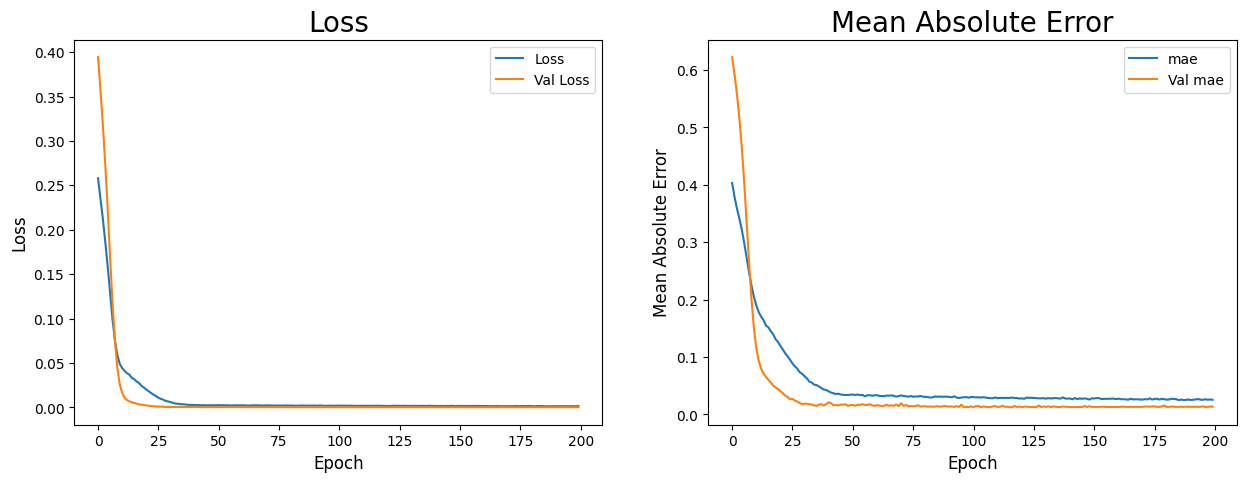

In [64]:
# Membuat grafik untuk menunjukkan nilai Loss dan MAER dari model 'saham_byd'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Loss
ax1.plot(saham_byd.history['loss'])
ax1.plot(saham_byd.history['val_loss'])
ax1.legend(['Loss','Val Loss'])
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss', fontsize=20)

# MAE
ax2.plot(saham_byd.history['mae'])
ax2.plot(saham_byd.history['val_mae'])
ax2.legend(['mae','Val mae'])
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Mean Absolute Error', fontsize=12)
ax2.set_title('Mean Absolute Error', fontsize=20)
plt.show()

In [65]:
# Evaluasi model prediksi Tesla
mae_tesla = mean_absolute_error(Y_test_tesla, pred_tesla)
mse_tesla = mean_squared_error(Y_test_tesla, pred_tesla)
rmse_tesla = np.sqrt(mean_squared_error(Y_test_tesla, pred_tesla))
mape_tesla = mean_absolute_percentage_error(Y_test_tesla, pred_tesla)
print('MAE: ', mae_tesla)
print('MSE: ', mse_tesla)
print('RMSE: ', rmse_tesla)
print('MAPE: ', mape_tesla)

MAE:  0.014885308556812357
MSE:  0.00038530379317683176
RMSE:  0.019629156710792028
MAPE:  0.02909356210182543


In [66]:
# Evaluasi model prediksi BYD
mae_byd = mean_absolute_error(Y_test_byd, pred_byd)
mse_byd = mean_squared_error(Y_test_byd, pred_byd)
rmse_byd = np.sqrt(mean_squared_error(Y_test_byd, pred_byd))
mape_byd = mean_absolute_percentage_error(Y_test_byd, pred_byd)
print('MAE: ', mae_byd)
print('MSE: ', mse_byd)
print('RMSE: ', rmse_byd)
print('MAPE: ', mape_byd)

MAE:  0.013555672794324623
MSE:  0.00028974190921619397
RMSE:  0.01702180687283797
MAPE:  0.020861868759650487


# **6. PREDICTING**


Setelah dilakukan uji validitas dari model yang akan digunakan pada data latih terhadap data uji, selanjutnya dilakukan prediksi dari data yang ada untuk mengetahui potensi harga dari kedua perusahaan.

### **6.1. Prediksi Satu Hari Kedepan**

In [67]:
df_pred = pd.DataFrame()
def one_day(data, model, scaler, company):
  global df_pred
  last_data = data.values[-1].reshape(-1, 1)
  last_data = last_data.reshape((1, 1, 1))
  predicted_scaled = model.predict(last_data)
  predicted_close = scaler.inverse_transform(predicted_scaled)
  predicted_date = pd.Timestamp('2024-06-29')
  print(f"Prediksi harga saham {company} untuk {predicted_date} adalah: $ {predicted_close[0][0]:.2f}")

  #if predicted_date in df_pred.index:
  #  df_pred.loc[predicted_date, f'Prediction {company}'] = predicted_close[0][0]
  #else:
  #  new_row = pd.DataFrame({f'Prediction {company}': predicted_close[0][0]}, index=[predicted_date])
  #  df_pred = pd.concat([df_pred, new_row])


  return predicted_close[0][0]

In [68]:
predict_close_tesla = one_day(df_3['scaled_tesla'], model_tesla, scale_tesla, 'Tesla')
predict_close_byd = one_day(df_3['scaled_byd'], model_byd, scale_byd, 'BYD')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediksi harga saham Tesla untuk 2024-06-29 00:00:00 adalah: $ 193.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediksi harga saham BYD untuk 2024-06-29 00:00:00 adalah: $ 58.60


### **6.2. Prediksi Saham 60 Hari Ke Depan**

In [69]:
  # Membuat range tanggal untuk 60 hari ke depan
def future_days(data, model, scaler, company, period):
    global df_future
    last_date = df_3.index[-1]
    all_future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=period)

    future_dates = all_future_dates[all_future_dates.weekday < 5]
    future_dates = future_dates[:period]
    week_days = len(future_dates)

    # Menyiapkan data untuk prediksi
    future_pred = []
    last_data= data.values[-1].reshape(-1, 1)
    last_data = last_data.reshape((1, 1, 1))

    for _ in range(week_days):
        predicted_scaled = model.predict(last_data)
        predicted_close = scaler.inverse_transform(predicted_scaled)
        future_pred.append(predicted_close[0][0])
        last_data = predicted_scaled.reshape((1, 1, 1))

    df_future = pd.DataFrame({f'Prediction {company}': future_pred}, index=future_dates)

    return df_future

In [70]:
predict_60_tesla = future_days(df_3['scaled_tesla'], model_tesla, scale_tesla, 'Tesla', 60)
predict_60_byd = future_days(df_3['scaled_byd'], model_byd, scale_byd, 'BYD', 60)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

In [71]:
# Mencetak Hasil Prediksi 60 Hari
predict_60_tesla

,Prediction Tesla
2024-07-01,193.544678
2024-07-02,189.219131
2024-07-03,184.921204
2024-07-04,180.668427
2024-07-05,176.477676
2024-07-08,172.364944
2024-07-09,168.345123
2024-07-10,164.431793
2024-07-11,160.636948
2024-07-12,156.971054


In [72]:
# Mencetak hasil prediksi 60 hari
predict_60_byd

,Prediction BYD
2024-07-01,58.599800
2024-07-02,58.151043
2024-07-03,57.732410
2024-07-04,57.342556
2024-07-05,56.980061
2024-07-08,56.643501
2024-07-09,56.331440
2024-07-10,56.042477
2024-07-11,55.775211
2024-07-12,55.528275


In [73]:
# Menggabungkan hasil prediksi Tesla dan BYD
df_predict_60 = pd.concat([predict_60_tesla, predict_60_byd], axis=1)
print(df_predict_60)

            Prediction Tesla  Prediction BYD
2024-07-01        193.544678       58.599800
2024-07-02        189.219131       58.151043
2024-07-03        184.921204       57.732410
2024-07-04        180.668427       57.342556
2024-07-05        176.477676       56.980061
2024-07-08        172.364944       56.643501
2024-07-09        168.345123       56.331440
2024-07-10        164.431793       56.042477
2024-07-11        160.636948       55.775211
2024-07-12        156.971054       55.528275
2024-07-15        153.442825       55.300362
2024-07-16        150.059265       55.090202
2024-07-17        146.825668       54.896580
2024-07-18        143.745667       54.718334
2024-07-19        140.821259       54.554371
2024-07-22        138.053055       54.403641
2024-07-23        135.440277       54.265160
2024-07-24        132.980927       54.138016
2024-07-25        130.672012       54.021339
2024-07-26        128.509613       53.914318
2024-07-29        126.489082       53.816200
2024-07-30

### **ALTERNATIF PREDIKSI**

#### **Prediksi 60 Hari Harga Saham Tesla**

In [74]:
# Membuat range tanggal untuk 60 hari ke depan
last_date = df_3.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=60)

# Menyiapkan data untuk prediksi
future_pred_tesla = []
last_data_tesla = df_3['scaled_tesla'].values[-1].reshape(-1, 1)
last_data_tesla = last_data_tesla.reshape((1, 1, 1))

for _ in range(60):
    predicted_scaled_tesla = model_tesla.predict(last_data_tesla)
    predicted_close = scale_tesla.inverse_transform(predicted_scaled_tesla)
    future_pred_tesla.append(predicted_close[0][0])
    last_data_tesla = predicted_scaled_tesla.reshape((1, 1, 1))

# Create a DataFrame for future predictions
df_60_tesla = pd.DataFrame({'Prediction Tesla': future_pred_tesla}, index=future_dates)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

In [75]:
# Mencetak tabel hasil prediksi saham Tesla
df_60_tesla

,Prediction Tesla
2024-06-29,193.544678
2024-06-30,189.219131
2024-07-01,184.921204
2024-07-02,180.668427
2024-07-03,176.477676
2024-07-04,172.364944
2024-07-05,168.345123
2024-07-06,164.431793
2024-07-07,160.636948
2024-07-08,156.971054


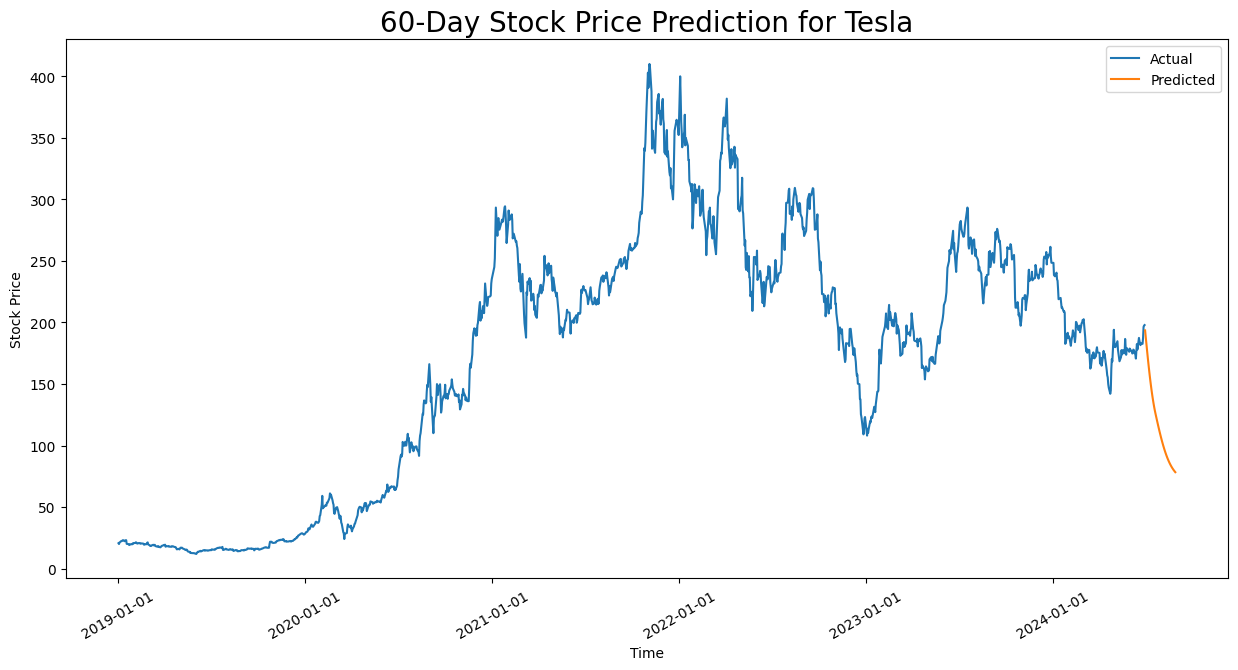

In [76]:
# Menggabungkan data hasil prediksi 'df_60_tesla' dengan dataset 'df_3'
df_extended = pd.concat([df_3, df_60_tesla])

# Melakukan visualisasi dari prediksi
plt.figure(figsize=(15, 7))
plt.plot(df_3.index, df_3['Tesla'], label='Actual')
plt.plot(df_60_tesla['Prediction Tesla'], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('60-Day Stock Price Prediction for Tesla', fontsize=20)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator()) #use auto locator for better date display
plt.xticks(rotation=30)
plt.legend()
plt.show()

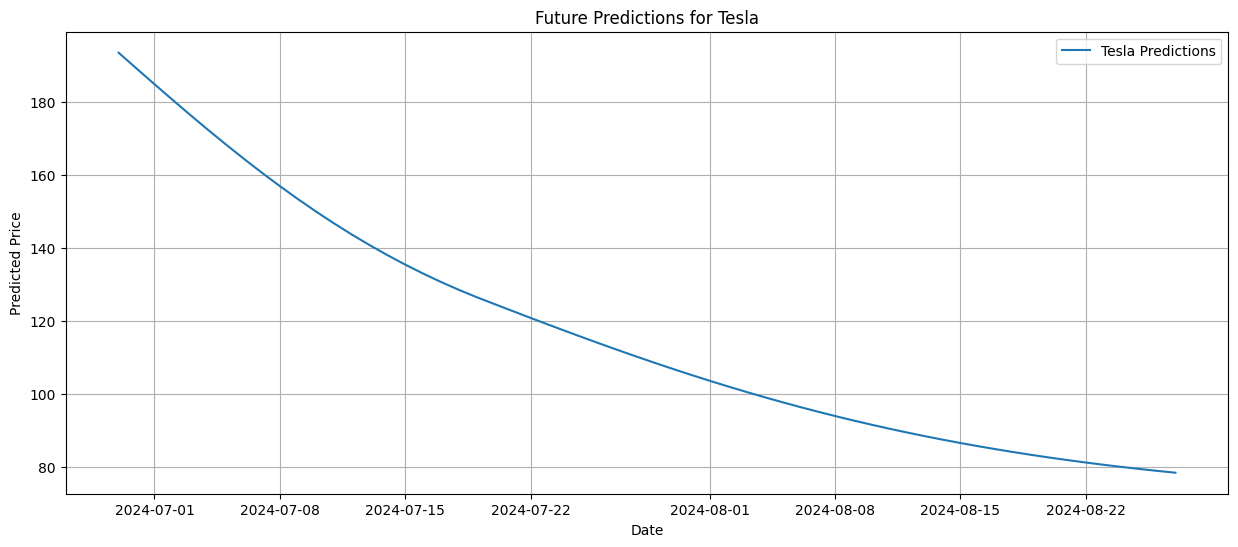

In [77]:
plt.figure(figsize=(15, 6))
plt.plot(df_60_tesla.index, df_60_tesla['Prediction Tesla'], label='Tesla Predictions')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.title('Future Predictions for Tesla')
plt.legend()
plt.grid(True)
plt.show()

#### **Prediksi 60 Hari Harga Saham BYD**

In [78]:
# Membuat range tanggal untuk 60 hari ke depan
last_date = df_3.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=60)

# Menyiapkan data untuk prediksi
future_pred_byd = []
last_data_byd = df_3['scaled_byd'].values[-1].reshape(-1, 1)
last_data_byd = last_data_byd.reshape((1, 1, 1))

for _ in range(60):
    # Predict the next day's scaled price
    predicted_close_scaled = model_byd.predict(last_data_byd)

    # Inverse transform to get the original price scale
    predicted_close = scale_byd.inverse_transform(predicted_close_scaled)
    future_pred_byd.append(predicted_close[0][0])

    # Update last_data with the predicted value for the next iteration
    last_data_byd = predicted_close_scaled.reshape((1, 1, 1))


# Create a DataFrame for future predictions
df_60_byd = pd.DataFrame({'Prediction BYD': future_pred_byd}, index=future_dates)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

In [79]:
# Mencetak tabel hasil prediksi saham BYD
df_60_byd

,Prediction BYD
2024-06-29,58.599800
2024-06-30,58.151043
2024-07-01,57.732410
2024-07-02,57.342556
2024-07-03,56.980061
2024-07-04,56.643501
2024-07-05,56.331440
2024-07-06,56.042477
2024-07-07,55.775211
2024-07-08,55.528275


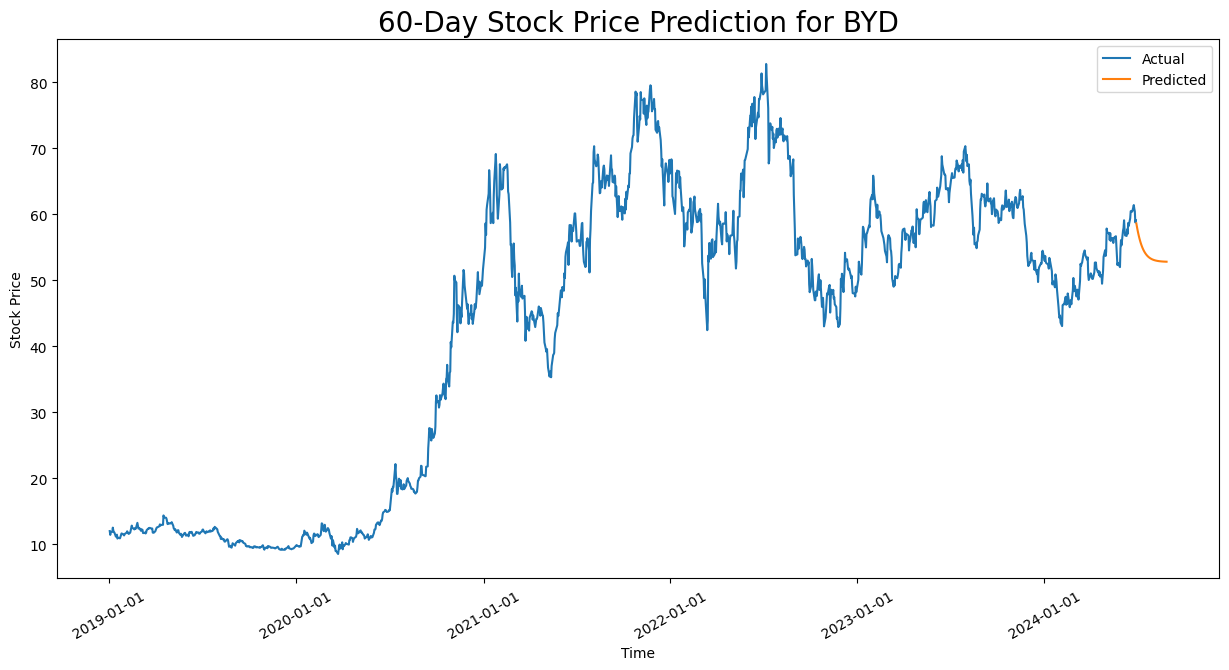

In [80]:
# Menggabungkan data hasil prediksi 'df_60_byd' dengan dataset 'df_3'
df_extended = pd.concat([df_3, df_60_byd])

# Melakukan visualisasi dari prediksi
plt.figure(figsize=(15, 7))
plt.plot(df_3.index, df_3['BYD'], label='Actual')
plt.plot(df_60_byd['Prediction BYD'], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('60-Day Stock Price Prediction for BYD', fontsize=20)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator()) #use auto locator for better date display
plt.xticks(rotation=30)
plt.legend()
plt.show()

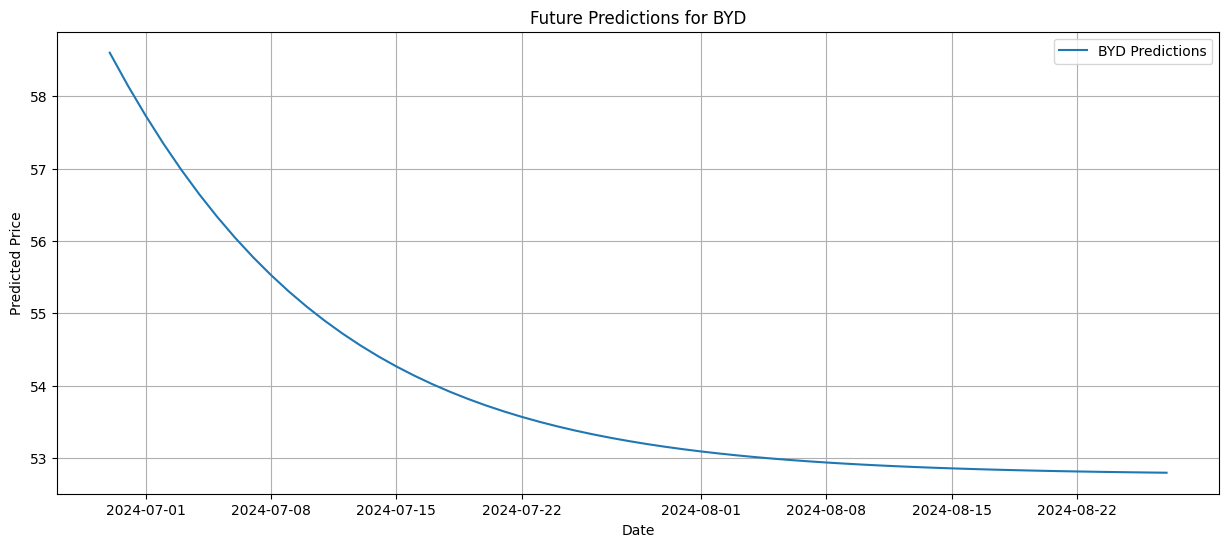

In [81]:
plt.figure(figsize=(15, 6))
plt.plot(df_60_byd.index, df_60_byd['Prediction BYD'], label='BYD Predictions')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.title('Future Predictions for BYD')
plt.legend()
plt.grid(True)
plt.show()

In [82]:
df_pred_60 = pd.concat([df_60_tesla, df_60_byd], axis=1)
print(df_pred_60)

            Prediction Tesla  Prediction BYD
2024-06-29        193.544678       58.599800
2024-06-30        189.219131       58.151043
2024-07-01        184.921204       57.732410
2024-07-02        180.668427       57.342556
2024-07-03        176.477676       56.980061
2024-07-04        172.364944       56.643501
2024-07-05        168.345123       56.331440
2024-07-06        164.431793       56.042477
2024-07-07        160.636948       55.775211
2024-07-08        156.971054       55.528275
2024-07-09        153.442825       55.300362
2024-07-10        150.059265       55.090202
2024-07-11        146.825668       54.896580
2024-07-12        143.745667       54.718334
2024-07-13        140.821259       54.554371
2024-07-14        138.053055       54.403641
2024-07-15        135.440277       54.265160
2024-07-16        132.980927       54.138016
2024-07-17        130.672012       54.021339
2024-07-18        128.509613       53.914318
2024-07-19        126.489082       53.816200
2024-07-20

### **4.5.3. Prediksi 100 Hari**

In [83]:
predict_100_tesla = future_days(df_3['scaled_tesla'], model_tesla, scale_tesla, 'Tesla', 100)
predict_100_byd = future_days(df_3['scaled_byd'], model_byd, scale_byd, 'BYD', 100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

In [84]:
print(f'Prediksi Saham Tesla 100 Hari:\n {predict_100_tesla}')
print(f'Prediksi Saham BYD 100 Hari:\n {predict_100_byd}')

Prediksi Saham Tesla 100 Hari:
             Prediction Tesla
2024-07-01        193.544678
2024-07-02        189.219131
2024-07-03        184.921204
2024-07-04        180.668427
2024-07-05        176.477676
...                      ...
2024-09-30         75.901283
2024-10-01         75.566391
2024-10-02         75.250626
2024-10-03         74.953003
2024-10-04         74.672577

[70 rows x 1 columns]
Prediksi Saham BYD 100 Hari:
             Prediction BYD
2024-07-01       58.599800
2024-07-02       58.151043
2024-07-03       57.732410
2024-07-04       57.342556
2024-07-05       56.980061
...                    ...
2024-09-30       52.783691
2024-10-01       52.782173
2024-10-02       52.780781
2024-10-03       52.779510
2024-10-04       52.778355

[70 rows x 1 columns]


In [85]:
# Mencetak Hasil Prediksi Harga Saham 100 Hari
predict_100_tesla

,Prediction Tesla
2024-07-01,193.544678
2024-07-02,189.219131
2024-07-03,184.921204
2024-07-04,180.668427
2024-07-05,176.477676
...,...
2024-09-30,75.901283
2024-10-01,75.566391
2024-10-02,75.250626
2024-10-03,74.953003


In [86]:
# Mencetak Hasil Prediksi Harga Saham 100 Hari
predict_100_byd

,Prediction BYD
2024-07-01,58.599800
2024-07-02,58.151043
2024-07-03,57.732410
2024-07-04,57.342556
2024-07-05,56.980061
...,...
2024-09-30,52.783691
2024-10-01,52.782173
2024-10-02,52.780781
2024-10-03,52.779510


In [87]:
df_predict_100 = pd.concat([predict_100_tesla, predict_100_byd], axis=1)
print(df_predict_100)

            Prediction Tesla  Prediction BYD
2024-07-01        193.544678       58.599800
2024-07-02        189.219131       58.151043
2024-07-03        184.921204       57.732410
2024-07-04        180.668427       57.342556
2024-07-05        176.477676       56.980061
...                      ...             ...
2024-09-30         75.901283       52.783691
2024-10-01         75.566391       52.782173
2024-10-02         75.250626       52.780781
2024-10-03         74.953003       52.779510
2024-10-04         74.672577       52.778355

[70 rows x 2 columns]


In [88]:
# @title
def days_until_input(input_date_str):
  try:
    input_date = datetime.strptime(input_date_str, '%Y-%m-%d').date()
    last_date = df_3.index[-1].date()
    delta = input_date - last_date
    return delta.days
  except ValueError:
    print("Incorrect data format, should be YYYY-MM-DD")
    return None

# Example usage
#input_date = input("Masukkan tanggal (format: YYYY-MM-DD): ")
input_date = "2024-11-01"
if input_date in df_predict_100.index:
  days = 0
  print(df_predict_100[df_predict_100.index==input_date])
else:
  days = days_until_input(input_date)

  pred_random_tesla = future_days(df_3[f'scaled_tesla'], model_tesla, scale_tesla, 'Tesla', days)
  pred_random_byd = future_days(df_3[f'scaled_byd'], model_byd, scale_byd, 'BYD', days)

  print(f'Prediksi Harga Saham pada tanggal {input_date} adalah ')
  print('Tesla: ', pred_random_tesla.values[-1], 'BYD: ', pred_random_byd.values[-1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

# **7. VISUALISASI**


Bagian ini adalah bagian untuk menilai/mengevaluasi model yang telah digunakan serta mengukur tingkat akurasi model.

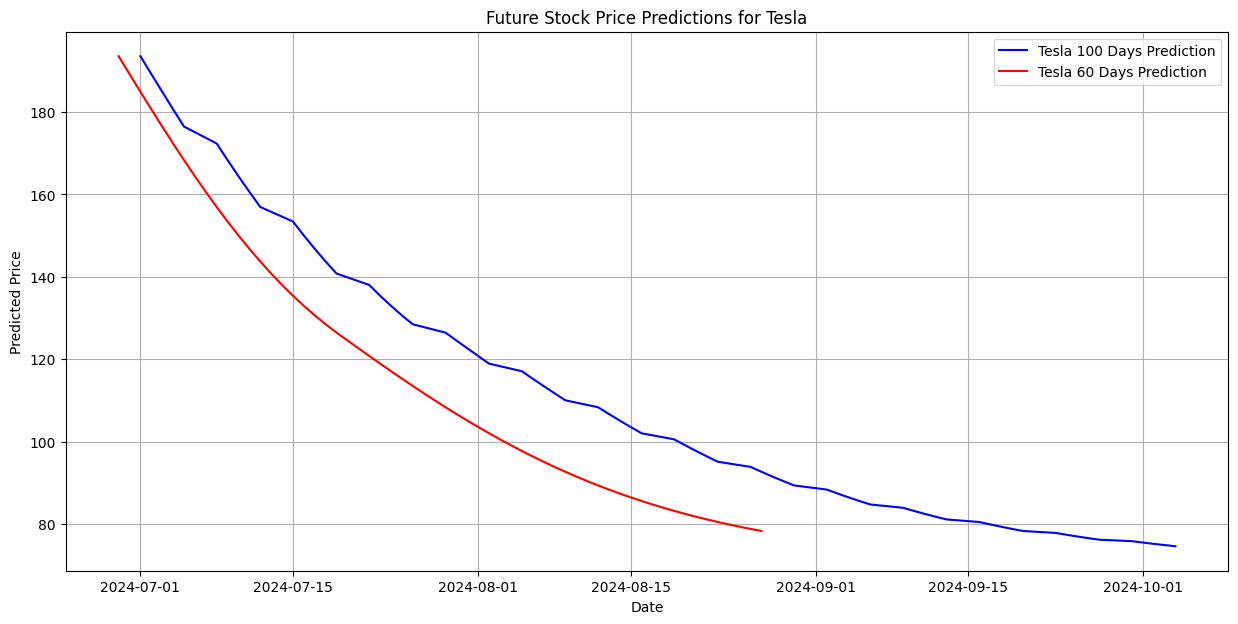

In [89]:
# Visualisasi
plt.figure(figsize=(15, 7))
plt.plot(df_predict_100.index, df_predict_100['Prediction Tesla'], color='Blue', label= 'Tesla 100 Days Prediction')
plt.plot(df_pred_60.index, df_pred_60['Prediction Tesla'], color='Red', label='Tesla 60 Days Prediction')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.title('Future Stock Price Predictions for Tesla')
plt.legend()
plt.grid(True)
plt.show()

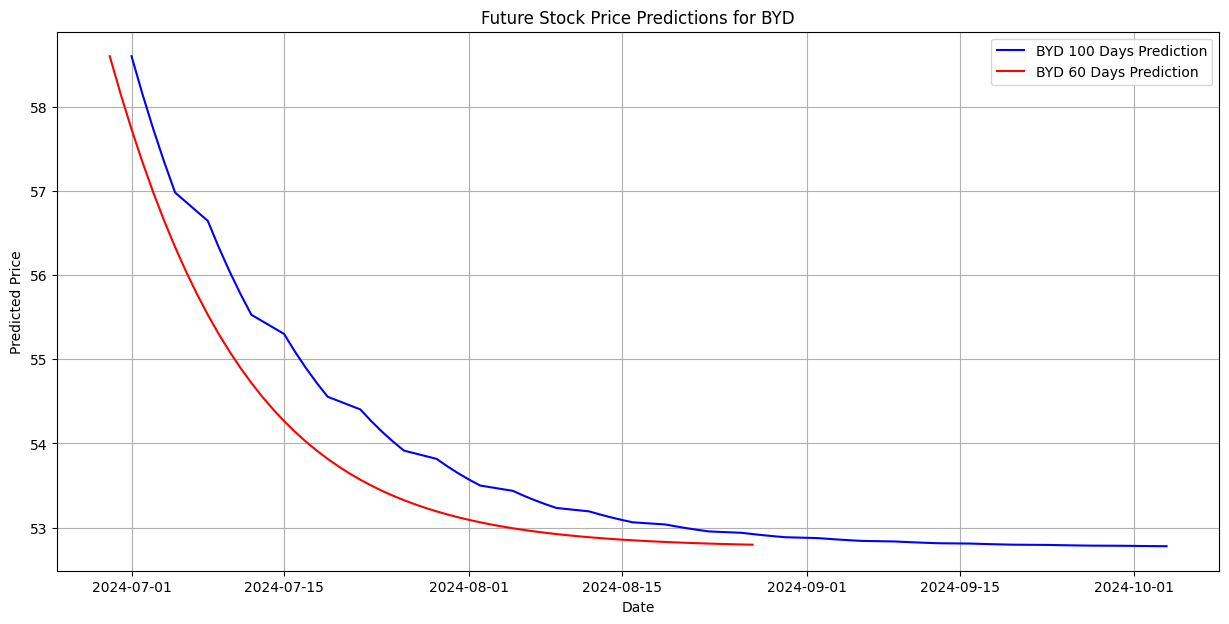

In [90]:
# Visualisasi
plt.figure(figsize=(15, 7))
plt.plot(df_predict_100.index, df_predict_100['Prediction BYD'], color='Blue', label= 'BYD 100 Days Prediction')
plt.plot(df_pred_60.index, df_pred_60['Prediction BYD'], color='Red', label='BYD 60 Days Prediction')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.title('Future Stock Price Predictions for BYD')
plt.legend()
plt.grid(True)
plt.show()

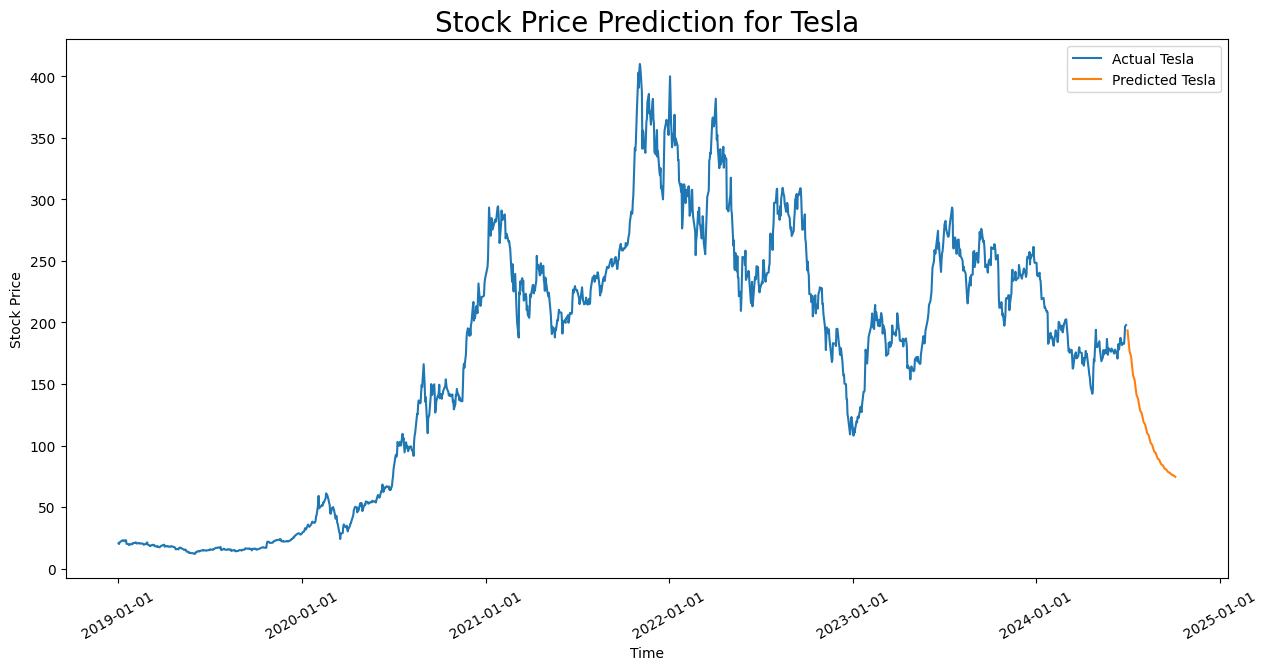

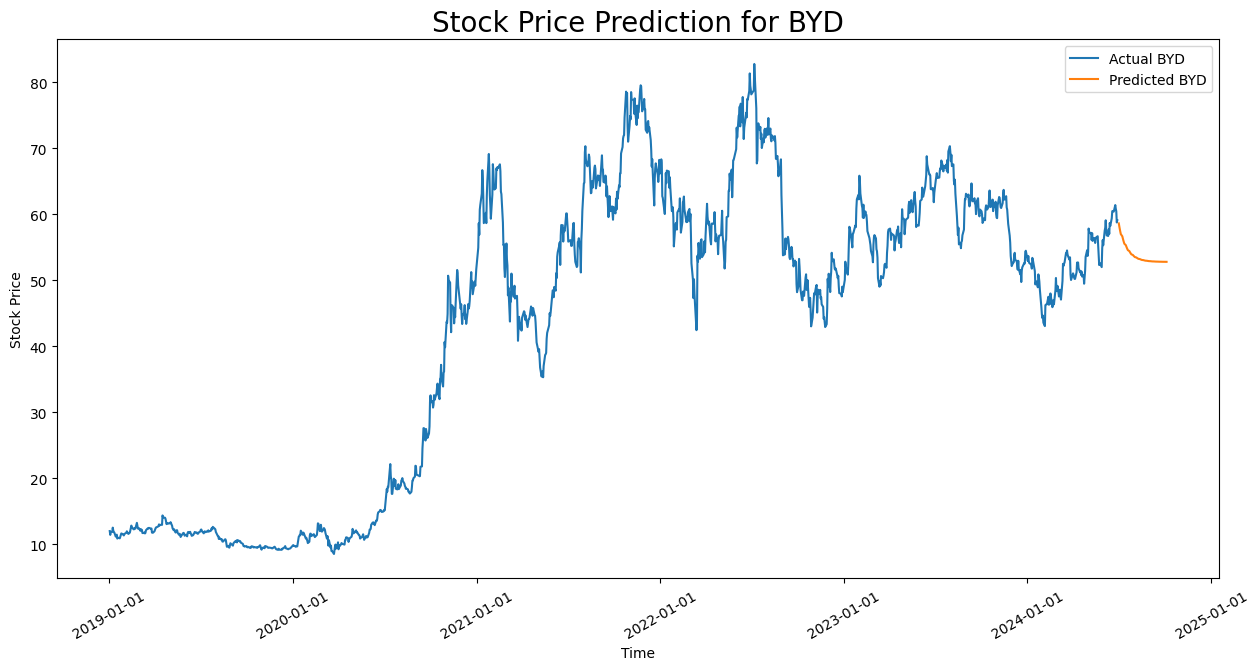

In [91]:
# Menggabungkan data hasil prediksi dengan dataset 'df_3'
df_extended = pd.concat([df_3, df_predict_100])

# Melakukan visualisasi dari prediksi
plt.figure(figsize=(15, 7))
plt.plot(df_3.index, df_3['Tesla'], label='Actual Tesla')
plt.plot(df_predict_100['Prediction Tesla'], label='Predicted Tesla')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction for Tesla', fontsize=20)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator()) #use auto locator for better date display
plt.xticks(rotation=30)
plt.legend()
plt.show()

# Melakukan visualisasi dari prediksi
plt.figure(figsize=(15, 7))
plt.plot(df_3.index, df_3['BYD'], label='Actual BYD')
plt.plot(df_predict_100['Prediction BYD'], label='Predicted BYD')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction for BYD', fontsize=20)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator()) #use auto locator for better date display
plt.xticks(rotation=30)
plt.legend()
plt.show()

In [92]:
# prompt: save df_predict_100 and df_pred_60 to excel
df_combined = pd.concat([df_predict_100, df_predict_60], axis=1)
df_combined

df_combined.to_excel('df_predictiction.xlsx')